# Love in the Time of Mobile Money: Valentine's Day M-Pesa Transfers in Kenya
### Technical Analysis Notebook

**Author:** Collins Ogombo  
**Date:** 2025-02-14

This notebook reproduces the full analytical workflow behind the report *Love in the Time of Mobile Money*, using a synthetic dataset modeled on realistic M-Pesa usage patterns and Kenyan Valentine’s spending trends.

## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random

#ignore warnings
import warnings
warnings.filterwarnings('ignore')


# visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

## 2. Generate Synthetic Dataset
This section creates a synthetic but realistic dataset based on known M-Pesa usage patterns, Valentine’s spending behaviour, and documented demographic trends.

In [3]:
# ==============================================================================
# 1. CONSTANTS & CONFIGURATION(KENYAN CONTEXT)
# ==============================================================================

# Top 10 Spending Counties 
KENYAN_VALENTINE_COUNTIES = [
    'Nairobi', 'Mombasa', 'Nakuru', 'Kwale', 'Kisumu', 
    'Kajiado', 'Kiambu', 'Laikipia', 'Uasin Gishu', 'Machakos', 'Kilifi', 'Narok'
]

# --- Probability Distributions (Normalized) ---

def normalize_weights(weights):
    """Helper function to ensure weights sum exactly to 1.0."""
    total = sum(weights)
    return [w / total for w in weights]

BASELINE_COUNTY_WEIGHTS = normalize_weights([
    0.28, 0.17, 0.06, 0.04, 0.04, 0.03, 0.09, 0.01, 0.039, 0.010, 0.010, 0.221
]) #Weights approximate general population/economic activity


VALENTINE_COUNTY_WEIGHTS = normalize_weights([
    0.34, 0.12, 0.07, 0.03, 0.05, 0.04, 0.10, 0.02, 0.03, 0.02, 0.10, 0.08
])

# Hourly transaction probability:Weighted towards active hours(Low at night, peak morning/evening)
BASELINE_HOUR_PROBS = normalize_weights([
    0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, # 00-05
    0.0380, 0.0571, 0.0666, 0.0476, 0.0380, 0.0476, # 06-11
    0.0666, 0.0571, 0.0476, 0.0380, 0.0476, 0.0666, # 12-17
    0.0761, 0.0857, 0.0666, 0.0476, 0.0285, 0.0190  # 18-23
])  

# ==============================================================================
# 2. BASELINE TRANSACTIONS GENERATION (Feb 1-10)
# ==============================================================================

def generate_baseline_transactions(n_users=10000, days_before_valentine=10):
    """
    Generate baseline M-Pesa transactions before Valentine's week (Feb 1-10).
    Based on Safaricom's PLC Annual Report FY24: ~37 chargeable transfers,(inclusive of P2P transfers) per user monthly.
    Amount estimates are based on survey studies by TIFA, and other reputable sources focused on Mpesa usage in Kenya.      """
    print(f"Generating Baseline Data for {days_before_valentine} days...")
    transactions = []
    start_date = datetime(2025, 2, 1)
    
    for day in range(days_before_valentine):
        current_date = start_date + timedelta(days=day)
        # ~37 transfers/month -> ~1.23/day
        daily_transactions = int(n_users * 1.23) 
        
        for _ in range(daily_transactions):
            # Amount distribution (General baseline) Logic
            amt_cat = np.random.choice(['micro', 'small', 'medium', 'large'], p=[0.40, 0.35, 0.20, 0.05])
            if amt_cat == 'micro': 
                amount = np.random.uniform(50, 500)
            elif amt_cat == 'small': 
                amount = np.random.uniform(500, 2000)
            elif amt_cat == 'medium': 
                amount = np.random.uniform(2000, 10000)
            else: 
                amount = np.random.uniform(10000, 50000)
            
            # Demographics: County/location/Gender Distribution
            county = np.random.choice(KENYAN_VALENTINE_COUNTIES, p=BASELINE_COUNTY_WEIGHTS)
            is_urban_core = county in ['Nairobi', 'Mombasa', 'Nakuru', 'Kisumu', 'Uasin Gishu']
            location_type = 'Urban' if is_urban_core else np.random.choice(['Urban', 'Rural'], p=[0.40, 0.60])
            
            gender_pattern = np.random.choice(
                ['M_to_F', 'F_to_M', 'M_to_M', 'F_to_F'], p=[0.35, 0.30, 0.15, 0.20]
            )
            
            transactions.append({
                'date': current_date,
                'hour': int(np.random.choice(range(24), p=BASELINE_HOUR_PROBS)),
                'amount': round(amount, 2),
                'amount_category': amt_cat, # Added for consistency
                'county': county,
                'location_type': location_type,
                'gender_pattern': gender_pattern,
                'is_valentine_related': False,
                'period': 'baseline',
            })
            
    return pd.DataFrame(transactions)

# ==============================================================================
# 3. VALENTINE'S TRANSACTIONS GENERATION (Feb 11-14)
# ==============================================================================

def generate_valentine_transactions(n_users=10000):
    """
    Generate Valentine's Day M-Pesa transactions incorporating Kenyan context.
    Incorporates surge patterns and behavioral insights.
    """
    print("Generating Valentine's Surge Data...")
    transactions = []
    
    valentine_dates = [
        (datetime(2025, 2, 11), 0.18, "Early Planners"), #Tuesday - 18%
        (datetime(2025, 2, 12), 0.22, "Getting Serious"), #Wednesday - 22%
        (datetime(2025, 2, 13), 0.31, "Panic Mode"),      #Thursday - 31%
        (datetime(2025, 2, 14), 0.29, "Valentine's Day")    #Friday - 29%
    ]
    
    # Hour distributions defined(Specific Valentine Day Peaks)
    panic_hour_probs = normalize_weights([0.005]*5 + [0.01, 0.02, 0.03, 0.04, 0.03, 0.03, 0.04, 0.06, 0.05, 0.04, 0.04, 0.05, 0.08, 0.12, 0.14, 0.10, 0.08, 0.06, 0.04])
    val_day_probs = normalize_weights([0.005]*4 + [0.01, 0.02, 0.04, 0.07, 0.08, 0.05, 0.04, 0.05, 0.08, 0.10, 0.09, 0.05, 0.05, 0.07, 0.09, 0.10, 0.08, 0.05, 0.03, 0.02])
    standard_val_probs = normalize_weights([0.01]*5 + [0.02, 0.04, 0.06, 0.07, 0.05, 0.05, 0.06, 0.08, 0.07, 0.06, 0.05, 0.05, 0.07, 0.08, 0.08, 0.06, 0.04, 0.03, 0.02])

    # Total Valentine's transfers (145% surge from baseline): Base volume * 4 days * 2.45x surge multiplier
    total_valentine_transfers = int(n_users * 1.23 * 4 * 2.45)
    
    for date, proportion, day_type in valentine_dates:
        daily_transfers = int(total_valentine_transfers * proportion)
        
        # Select hourly probability based on day type
        if day_type == "Panic Mode": current_hour_p = panic_hour_probs
        elif day_type == "Valentine's Day": current_hour_p = val_day_probs
        else: current_hour_p = standard_val_probs

        for _ in range(daily_transfers):
            # Amount distribution (Higher amounts for Valentine Day)
            amt_cat = np.random.choice(
                ['budget', 'mid-range', 'big-spender', 'ultra-romantic'],
                p=[0.40, 0.35, 0.20, 0.05]
            )
            
            if amt_cat == 'budget': 
                amount = np.random.uniform(200, 500)
            elif amt_cat == 'mid-range': 
                amount = np.random.uniform(500, 2000)
            elif amt_cat == 'big-spender': 
                amount = np.random.uniform(2000, 10000)
            else: 
                amount = np.random.uniform(10000, 100000)
            
            if np.random.random() < 0.60: # Round numbers (Psychology of gifting during Valentines)
                amount = round(amount / 100) * 100
            
            # Demographics (Valentines surged Weights)
            county = np.random.choice(KENYAN_VALENTINE_COUNTIES, p=VALENTINE_COUNTY_WEIGHTS)
            location_type = 'Urban' if county in ['Nairobi', 'Mombasa', 'Nakuru', 'Kisumu', 'Uasin Gishu'] else \
                           np.random.choice(['Urban', 'Rural'], p=[0.55, 0.45])
            
            # Men send more on Valentines compared to women
            gender_pattern = np.random.choice(['M_to_F', 'F_to_M', 'M_to_M', 'F_to_F'], p=[0.62, 0.28, 0.04, 0.06])
            
            # Contextual Romantic Messages sent by Kenyans
            message = np.random.choice([
                'Happy Valentines ❤️',                
                'Hii ni ya lunch babe',                 
                'Nakupenda sana 💕',                     
                'Dinner & surprise',                    
                'Ya maua na keki',                      
                'Tuende Out kesho for Val. Nimetumaya Uber, meet at 7 hapo Kempinski',            
                'Emergency Valentines for You',               
                'Happy Mens Conference 🍻',            
                'Iko nini Baby Girl? Check your Mpesa',                
                'Hii ni ya Uber',                  
                'Ni confirmed! ❤️'
            ], p=normalize_weights([18, 15, 12, 10, 9, 8, 7, 6, 5, 5, 5]))
            
            transactions.append({
                'date': date,
                'hour': int(np.random.choice(range(24), p=current_hour_p)),
                'amount': round(amount, 2),
                'amount_category': amt_cat,
                'county': county,
                'location_type': location_type,
                'gender_pattern': gender_pattern,
                'is_valentine_related': True,
                'period': 'valentine',
                'message_type': message,
                'day_type': day_type,
                'is_serial_romantic': np.random.random() < 0.23, #Serial romantics (23% send to multiple people)
                'relationship_status': np.random.choice(['Long-Term/Spouse', 'Dating', 'Sponsor', 'Hookup', 'Family'], p=[0.40, 0.30, 0.15, 0.10, 0.05]),#Relationship status of sender/receiver during Valentine's
                'event_type': np.random.choice(['Dinner', 'Getaway Vacation', 'Gift', 'Transport/Uber', 'Cash for Flowers/Chocolate', 'Drinks & Clubbing', 'Spa Day'], p=[0.30, 0.25, 0.15, 0.10, 0.10, 0.05, 0.05]),
                'is_apology': False
            })
            
    return pd.DataFrame(transactions)

# ==============================================================================
# 4. POST-VALENTINE TRANSACTIONS RECOVERY (Feb 15-28)
# ==============================================================================

def generate_post_valentine_transactions(n_users=10000, days_after=14):
    """
    Generate Post-Valentine's(Feb 15,2025) Day M-Pesa transactions reflecting recovery patterns."""
    print("Generating Post-Valentine Recovery Data...")
    transactions = []
    start_date = datetime(2025, 2, 15)
    
    for day in range(days_after):
        current_date = start_date + timedelta(days=day)
        
        # Economic recovery curve:drops initially, recovers to baseline
        if day < 3: 
            daily_multiplier = 0.68  # The "Mwezi uko corner" effect - 32% drop
        elif day < 6: 
            daily_multiplier = 0.85 # Gradual recovery - 15% drop
        else: 
            daily_multiplier = 1.0  # Back to baseline
        
        daily_transactions = int(n_users * 1.23 * daily_multiplier)
        
        # Feb 15th spike (The "Sorry I forgot" wave)
        if day == 0: daily_transactions = int(daily_transactions * 1.15)
            
        for _ in range(daily_transactions):
            # Amount distribution (reverts to baseline pattern)
            amt_cat = np.random.choice(['micro', 'small', 'medium', 'large'], p=[0.40, 0.35, 0.20, 0.05])
            if amt_cat == 'micro': 
                amount = np.random.uniform(50, 500)
            elif amt_cat == 'small': 
                amount = np.random.uniform(500, 2000)
            elif amt_cat == 'medium': 
                amount = np.random.uniform(2000, 10000)
            else: 
                amount = np.random.uniform(10000, 50000)
            
            # Apology transfers on Feb 15 are higher
            is_apology = False
            if day == 0 and np.random.random() < 0.15:
                amount *= 1.22 # The apology tax - 22% higher amounts
                is_apology = True
            
            county = np.random.choice(KENYAN_VALENTINE_COUNTIES, p=BASELINE_COUNTY_WEIGHTS)
            location_type = 'Urban' if county in ['Nairobi', 'Mombasa', 'Nakuru', 'Kisumu'] else np.random.choice(['Urban', 'Rural'], p=[0.40, 0.60])
            
            transactions.append({
                'date': current_date,
                'hour': int(np.random.choice(range(24), p=BASELINE_HOUR_PROBS)),
                'amount': round(amount, 2),
                'amount_category': amt_cat,
                'county': county,
                'location_type': location_type,
                'gender_pattern': np.random.choice(['M_to_F', 'F_to_M', 'M_to_M', 'F_to_F'], p=[0.40, 0.30, 0.15, 0.15]),
                'is_valentine_related': False,
                'period': 'post_valentine',
                'message_type': 'Apology' if is_apology else None,
                'day_type': 'Recovery',
                'is_serial_romantic': False,
                'relationship_status': None,
                'event_type': None,
                'is_apology': is_apology
            })
            
    return pd.DataFrame(transactions)



In [ ]:
def create_full_dataset(n_users=10000):
    """Combines all three periods into a single DataFrame."""
    df_baseline = generate_baseline_transactions(n_users=n_users)
    df_valentine = generate_valentine_transactions(n_users=n_users)
    df_post = generate_post_valentine_transactions(n_users=n_users)
    
    # Cleaning up columns for merging (adding placeholder values where needed)
    for df in [df_baseline, df_post]:
        if 'message_type' not in df.columns:
            df['message_type'] = 'General Transfer'
        if 'day_type' not in df.columns:
            df['day_type'] = 'Normal Day'
        if 'is_serial_romantic' not in df.columns:
            df['is_serial_romantic'] = False
        if 'relationship_status' not in df.columns:
            df['relationship_status'] = 'Unknown/General'
        if 'event_type' not in df.columns:
            df['event_type'] = 'General Consumption'
        if 'is_apology' not in df.columns:
            df['is_apology'] = False

    # Reorder columns to match all three DataFrames
    cols = ['date', 'hour', 'amount', 'county', 'location_type', 'gender_pattern', 
            'message_type', 'day_type', 'is_serial_romantic', 'relationship_status', 
            'event_type', 'is_valentine_related', 'period', 'is_apology']
    
    df_baseline = df_baseline.reindex(columns=cols, fill_value=False)
    df_valentine = df_valentine.reindex(columns=cols, fill_value=False)
    df_post = df_post.reindex(columns=cols, fill_value=False)

    return pd.concat([df_baseline, df_valentine, df_post], ignore_index=True)



In [5]:
#Applying the function to create the full dataset: number of users is 50,000
full_df = create_full_dataset(n_users=50000)
print(full_df.shape)

Generating Baseline Data for 10 days...
Generating Valentine's Surge Data...
Generating Post-Valentine Recovery Data...
(1998257, 14)


In [6]:
# inspect data types
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998257 entries, 0 to 1998256
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   hour                  int64         
 2   amount                float64       
 3   county                object        
 4   location_type         object        
 5   gender_pattern        object        
 6   message_type          object        
 7   day_type              object        
 8   is_serial_romantic    bool          
 9   relationship_status   object        
 10  event_type            object        
 11  is_valentine_related  bool          
 12  period                object        
 13  is_apology            bool          
dtypes: bool(3), datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 173.4+ MB


In [7]:
#preview the dataset
full_df.head()

,date,hour,amount,county,location_type,gender_pattern,message_type,day_type,is_serial_romantic,relationship_status,event_type,is_valentine_related,period,is_apology
0,2025-02-01,9,3305.45,Nairobi,Urban,F_to_M,General Transfer,Normal Day,False,Unknown/General,General Consumption,False,baseline,False
1,2025-02-01,8,5658.38,Narok,Rural,F_to_M,General Transfer,Normal Day,False,Unknown/General,General Consumption,False,baseline,False
2,2025-02-01,22,120.61,Narok,Rural,M_to_M,General Transfer,Normal Day,False,Unknown/General,General Consumption,False,baseline,False
3,2025-02-01,12,1410.80,Kisumu,Urban,F_to_F,General Transfer,Normal Day,False,Unknown/General,General Consumption,False,baseline,False
4,2025-02-01,21,989.79,Nakuru,Urban,F_to_F,General Transfer,Normal Day,False,Unknown/General,General Consumption,False,baseline,False


In [ ]:
#save as csv file
# full_df.to_csv('kenyas_valentine_mpesa_transactions.csv', index=False)

## 1. Exploratory Data Profiling

In [9]:
#A sample of 10 rows
full_df.sample(10)

,date,hour,amount,county,location_type,gender_pattern,message_type,day_type,is_serial_romantic,relationship_status,event_type,is_valentine_related,period,is_apology
1442786,2025-02-19,21,474.65,Narok,Urban,M_to_M,None,Recovery,False,None,None,False,post_valentine,False
264941,2025-02-05,20,650.36,Nairobi,Urban,M_to_F,General Transfer,Normal Day,False,Unknown/General,General Consumption,False,baseline,False
742121,2025-02-12,18,6280.60,Kilifi,Urban,F_to_M,Happy Mens Conference 🍻,Getting Serious,False,Family,Transport/Uber,True,valentine,False
1080414,2025-02-14,8,200.00,Nairobi,Urban,M_to_F,Happy Valentines ❤️,Valentine's Day,True,Family,Dinner,True,valentine,False
211311,2025-02-04,7,1728.42,Narok,Rural,F_to_M,General Transfer,Normal Day,False,Unknown/General,General Consumption,False,baseline,False
440797,2025-02-08,14,1494.07,Mombasa,Urban,F_to_M,General Transfer,Normal Day,False,Unknown/General,General Consumption,False,baseline,False
55211,2025-02-01,19,45912.76,Kiambu,Urban,M_to_M,General Transfer,Normal Day,False,Unknown/General,General Consumption,False,baseline,False
983776,2025-02-13,19,500.00,Nairobi,Urban,M_to_F,Hii ni ya Uber,Panic Mode,False,Dating,Getaway Vacation,True,valentine,False
1751786,2025-02-24,12,89.72,Nakuru,Urban,F_to_M,None,Recovery,False,None,None,False,post_valentine,False
1255334,2025-02-15,8,181.66,Kiambu,Urban,M_to_M,Apology,Recovery,False,None,None,False,post_valentine,True


In [10]:
print(f"Dataset generated with {full_df.shape[0]} transactions across {full_df['period'].nunique()} periods.")

Dataset generated with 1998257 transactions across 3 periods.


In [11]:
#date range check
print(f"Date range: {full_df['date'].min()} to {full_df['date'].max()}")

Date range: 2025-02-01 00:00:00 to 2025-02-28 00:00:00


In [12]:
# Total amount
print(f"The total amount is KES: {full_df.amount.sum():.2f}")

The total amount is KES: 7255357694.01


## 2. Data Preparation

In [13]:
# important variable: Number of users
number_of_users = 50000
print(f"Total number of users: {number_of_users}")

Total number of users: 50000


In [14]:
# Checking missing values in the dataset 
full_df.isnull().sum()

date                         0
hour                         0
amount                       0
county                       0
location_type                0
gender_pattern               0
message_type            773274
day_type                     0
is_serial_romantic           0
relationship_status     780557
event_type              780557
is_valentine_related         0
period                       0
is_apology                   0
dtype: int64

In [15]:
# Step 1: --Dealing with missing values--

full_df['relationship_status'].fillna('Unknown', inplace=True)
full_df['event_type'].fillna('General Consumption', inplace=True)
full_df['message_type'].fillna('General Transfer', inplace=True)


In [16]:
#verify changes in missing values 
full_df.isnull().sum()

date                    0
hour                    0
amount                  0
county                  0
location_type           0
gender_pattern          0
message_type            0
day_type                0
is_serial_romantic      0
relationship_status     0
event_type              0
is_valentine_related    0
period                  0
is_apology              0
dtype: int64

In [17]:
#gender pattern values
full_df['gender_pattern'].unique()

array([np.str_('F_to_M'), np.str_('M_to_M'), np.str_('F_to_F'),
       np.str_('M_to_F')], dtype=object)

In [18]:
# Step 2: --Column Transformation: For values in gender_pattern column, rename--:

# 'M_to_F' to 'Male_to_Female', 'F_to_M' to 'Female_to_Male','M_to_M' to 'Male_to_Male','F_to_F' to 'Female_to_Female'
full_df['gender_pattern'].replace({
    'M_to_F': 'Male_to_Female',
    'F_to_M': 'Female_to_Male',
    'M_to_M': 'Male_to_Male',
    'F_to_F': 'Female to_Female'
}, inplace=True)        


In [19]:
# verify changes in gender_pattern column
full_df['gender_pattern'].unique()

array(['Female_to_Male', 'Male_to_Male', 'Female to_Female',
       'Male_to_Female'], dtype=object)

In [20]:
# inspect relationship_status column
full_df['relationship_status'].unique()

array(['Unknown/General', np.str_('Hookup'), np.str_('Dating'),
       np.str_('Long-Term/Spouse'), np.str_('Sponsor'), np.str_('Family'),
       'Unknown'], dtype=object)

In [21]:
# Step 3: --Replace 'Unknown/General' and 'Unknown' with 'Complicated' in relationship_status column--
full_df['relationship_status'].replace({
    'Unknown/General': 'Complicated',
    'Unknown': 'Complicated'
}, inplace=True)

#verify changes in relationship_status column
full_df['relationship_status'].unique()

array(['Complicated', np.str_('Hookup'), np.str_('Dating'),
       np.str_('Long-Term/Spouse'), np.str_('Sponsor'), np.str_('Family')],
      dtype=object)

In [22]:
#Step 4: --Correcting location_type for:
#  Machakos, Kwale, Laikipia, Kilifi, Kiambu, Kajiado and Narok set to 'Rural'--
counties_to_correct = ['Machakos', 'Kwale', 'Laikipia', 'Kilifi', 'Kiambu', 'Kajiado', 'Narok']
full_df.loc[full_df['county'].isin(counties_to_correct), 'location_type'] = 'Rural'

# verify changes in location_type column
for county in counties_to_correct:
    print(f"{county} location types:\n{full_df[full_df['county']==county]['location_type'].value_counts()}\n")


Machakos location types:
location_type
Rural    26178
Name: count, dtype: int64

Kwale location types:
location_type
Rural    73922
Name: count, dtype: int64

Laikipia location types:
location_type
Rural    26105
Name: count, dtype: int64

Kilifi location types:
location_type
Rural    74145
Name: count, dtype: int64

Kiambu location types:
location_type
Rural    185952
Name: count, dtype: int64

Kajiado location types:
location_type
Rural    66097
Name: count, dtype: int64

Narok location types:
location_type
Rural    356634
Name: count, dtype: int64



In [23]:
# Step 5: -- Create a new column called 'amount_category' based on the amount ranges--
def categorize_amount(amount):
    if amount < 500:
        return 'micro romantics'
    elif 500 <= amount < 2000:
        return 'budget romantics'
    elif 2000 <= amount < 10000:
        return 'mid-range sweethearts'
    elif 10000 <= amount < 50000:
        return 'big-hearted lovers'
    elif 50000 <= amount < 100000:
        return 'ultra-romantic'
    else:
        return 'big-spender'  # For amounts >= 100,000
full_df['amount_category'] = full_df['amount'].apply(categorize_amount)

# verify amount_category column
full_df['amount_category'].value_counts()

amount_category
micro romantics          774909
budget romantics         718711
mid-range sweethearts    403915
big-hearted lovers        83958
ultra-romantic            16755
big-spender                   9
Name: count, dtype: int64

In [24]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998257 entries, 0 to 1998256
Data columns (total 15 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   hour                  int64         
 2   amount                float64       
 3   county                object        
 4   location_type         object        
 5   gender_pattern        object        
 6   message_type          object        
 7   day_type              object        
 8   is_serial_romantic    bool          
 9   relationship_status   object        
 10  event_type            object        
 11  is_valentine_related  bool          
 12  period                object        
 13  is_apology            bool          
 14  amount_category       object        
dtypes: bool(3), datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 188.7+ MB


In [25]:
# sample of cleaned dataset
full_df.sample(10)

,date,hour,amount,county,location_type,gender_pattern,message_type,day_type,is_serial_romantic,relationship_status,event_type,is_valentine_related,period,is_apology,amount_category
1209919,2025-02-14,19,200.00,Kiambu,Rural,Female_to_Male,Hii ni ya lunch babe,Valentine's Day,False,Long-Term/Spouse,Gift,True,valentine,False,micro romantics
1139005,2025-02-14,18,300.00,Kilifi,Rural,Female_to_Male,Happy Valentines ❤️,Valentine's Day,False,Hookup,Getaway Vacation,True,valentine,False,micro romantics
1914451,2025-02-27,18,668.34,Kwale,Rural,Male_to_Female,General Transfer,Recovery,False,Complicated,General Consumption,False,post_valentine,False,budget romantics
1018840,2025-02-13,17,403.35,Nairobi,Urban,Male_to_Female,Ya maua na keki,Panic Mode,False,Hookup,Getaway Vacation,True,valentine,False,micro romantics
697201,2025-02-11,18,4900.00,Nairobi,Urban,Male_to_Female,Dinner & surprise,Early Planners,False,Long-Term/Spouse,Getaway Vacation,True,valentine,False,mid-range sweethearts
225612,2025-02-04,20,376.89,Nairobi,Urban,Male_to_Female,General Transfer,Normal Day,False,Complicated,General Consumption,False,baseline,False,micro romantics
1523183,2025-02-21,17,948.45,Kiambu,Rural,Female_to_Male,General Transfer,Recovery,False,Complicated,General Consumption,False,post_valentine,False,budget romantics
1378279,2025-02-18,14,785.89,Mombasa,Urban,Female to_Female,General Transfer,Recovery,False,Complicated,General Consumption,False,post_valentine,False,budget romantics
1158400,2025-02-14,18,500.00,Narok,Rural,Male_to_Female,Hii ni ya lunch babe,Valentine's Day,False,Dating,Dinner,True,valentine,False,budget romantics
1448243,2025-02-19,13,170.72,Kisumu,Urban,Female to_Female,General Transfer,Recovery,False,Complicated,General Consumption,False,post_valentine,False,micro romantics


In [26]:
#final cleaned dataset # of rows and columns
print(f"The final dataste contains {full_df.shape[0]} rows and {full_df.shape[1]} columns after cleaning.")

The final dataste contains 1998257 rows and 15 columns after cleaning.


## 3. Summary Statistics

In [27]:
full_df.describe()

,date,hour,amount
count,1998257,1.998257e+06,1.998257e+06
mean,2025-02-14 02:25:48.453076992,1.388628e+01,3.630843e+03
min,2025-02-01 00:00:00,0.000000e+00,5.000000e+01
25%,2025-02-09 00:00:00,9.000000e+00,3.545500e+02
50%,2025-02-13 00:00:00,1.400000e+01,9.259300e+02
75%,2025-02-20 00:00:00,1.900000e+01,2.008310e+03
max,2025-02-28 00:00:00,2.300000e+01,1.000000e+05
std,NaN,5.443601e+00,9.342642e+03


## 4. Daily Transfers Volume

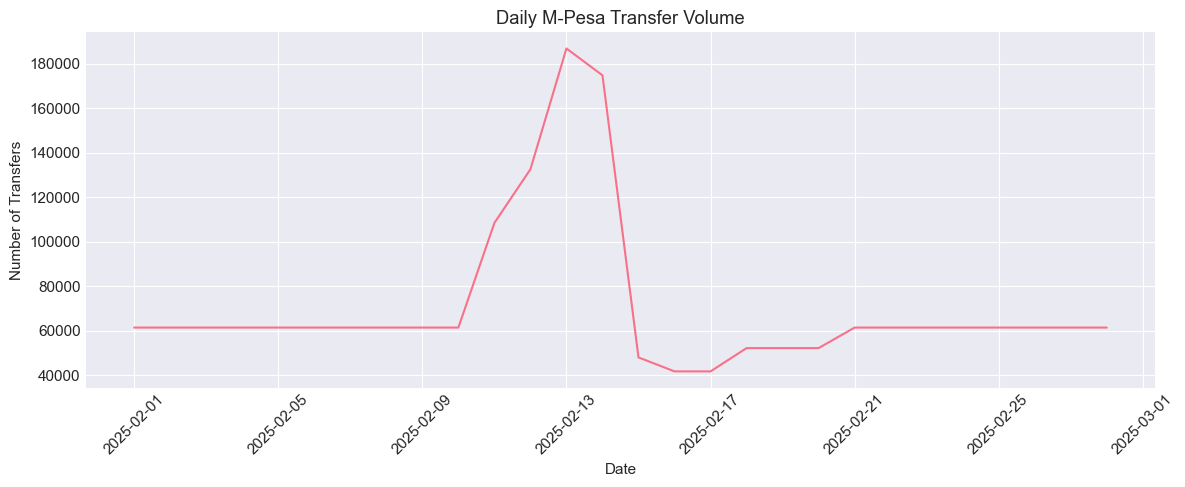

In [28]:
# Visualizing Daily Transfer Volume Trend
daily_counts_viz = full_df.groupby('date').size()

plt.figure(figsize=(12,5))
plt.plot(daily_counts_viz.index, daily_counts_viz.values)
plt.title('Daily M-Pesa Transfer Volume')
plt.xlabel('Date')
plt.ylabel('Number of Transfers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
print("\n1. DAILY TRANSACTION VOLUMES")
print("-"*70)
daily_volumes = full_df.groupby('date').agg({
    'amount': ['count', 'sum', 'mean', 'median']
}).round(2)
#add daily % change based on volume
daily_volumes['Pct_Change'] = daily_volumes['amount']['count'].pct_change().fillna(0).round(4) * 100
daily_volumes.columns = ['Transaction_Count', 'Total_Value_KSh', 'Mean_Amount', 'Median_Amount', 'Pct_Change']
daily_volumes.sort_values('Transaction_Count', ascending=False)


1. DAILY TRANSACTION VOLUMES
----------------------------------------------------------------------


,Transaction_Count,Total_Value_KSh,Mean_Amount,Median_Amount,Pct_Change
date,,,,,
2025-02-13,186837,8.465439e+08,4530.92,904.19,40.91
2025-02-14,174783,7.835516e+08,4483.00,900.00,-6.45
2025-02-12,132594,6.025369e+08,4544.22,916.40,22.22
2025-02-11,108486,4.878026e+08,4496.46,912.84,76.40
2025-02-04,61500,1.983001e+08,3224.39,924.00,0.00
2025-02-03,61500,2.011298e+08,3270.40,939.11,0.00
2025-02-05,61500,1.986829e+08,3230.62,922.20,0.00
2025-02-06,61500,2.021833e+08,3287.53,932.22,0.00
2025-02-08,61500,1.972313e+08,3207.01,919.22,0.00


In [30]:
# Daily transfer volume and proportion 
print("\n. DAILY TRANSFER VOLUME ANALYSIS")
print("-"*70)
daily_counts = full_df.groupby('date').size().sort_values(ascending=False)
daily_proportion = (daily_counts / len(full_df) * 100).round(2)
print("\nDaily Transfer Volume and Proportion (%):")
for date in daily_counts.index:
    print(f"{date.date()}: {daily_counts[date]} transfers ({daily_proportion[date]}%)")


. DAILY TRANSFER VOLUME ANALYSIS
----------------------------------------------------------------------

Daily Transfer Volume and Proportion (%):
2025-02-13: 186837 transfers (9.35%)
2025-02-14: 174783 transfers (8.75%)
2025-02-12: 132594 transfers (6.64%)
2025-02-11: 108486 transfers (5.43%)
2025-02-04: 61500 transfers (3.08%)
2025-02-03: 61500 transfers (3.08%)
2025-02-05: 61500 transfers (3.08%)
2025-02-06: 61500 transfers (3.08%)
2025-02-08: 61500 transfers (3.08%)
2025-02-07: 61500 transfers (3.08%)
2025-02-01: 61500 transfers (3.08%)
2025-02-02: 61500 transfers (3.08%)
2025-02-09: 61500 transfers (3.08%)
2025-02-10: 61500 transfers (3.08%)
2025-02-26: 61500 transfers (3.08%)
2025-02-25: 61500 transfers (3.08%)
2025-02-24: 61500 transfers (3.08%)
2025-02-23: 61500 transfers (3.08%)
2025-02-22: 61500 transfers (3.08%)
2025-02-21: 61500 transfers (3.08%)
2025-02-27: 61500 transfers (3.08%)
2025-02-28: 61500 transfers (3.08%)
2025-02-18: 52275 transfers (2.62%)
2025-02-19: 52275 tr

## 5. County Contribution Breakdown

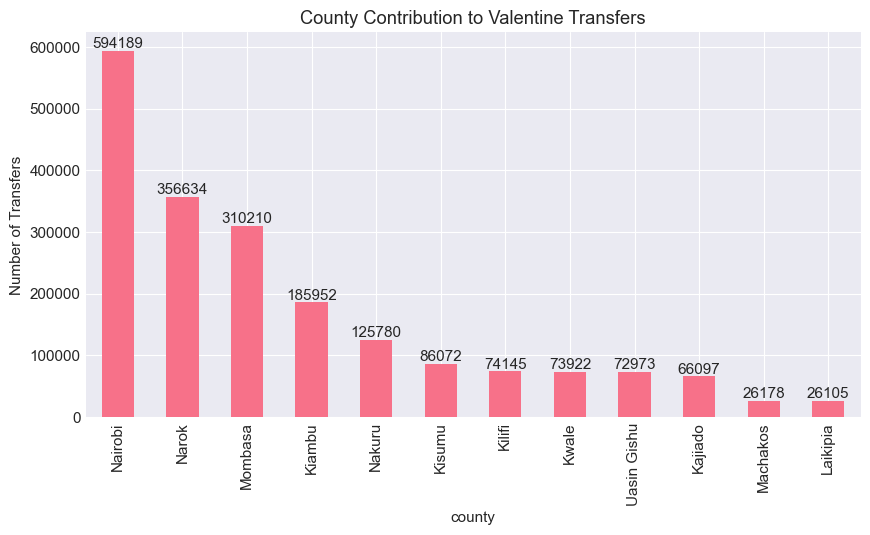

In [31]:
# visualize county contributions to Valentine transfers
plt.figure(figsize=(10,5))
full_df['county'].value_counts(normalize=False).plot(kind='bar')
plt.title('County Contribution to Valentine Transfers')
plt.ylabel('Number of Transfers')
#adding data labels
for index, value in enumerate(full_df['county'].value_counts(normalize=False)):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

## 6. Gender Pattern Breakdown

In [32]:
# gender pattern distribution(as percentage)
full_df['gender_pattern'].value_counts(normalize=True)*100 #percentage conversion

gender_pattern
Male_to_Female      45.078586
Female_to_Male      29.395969
Female to_Female    13.848519
Male_to_Male        11.676926
Name: proportion, dtype: float64

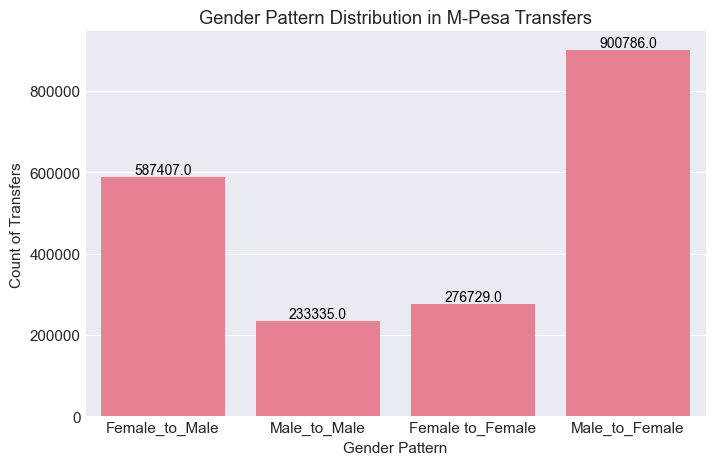

In [33]:
#gender_pattern distribution plot
plt.figure(figsize=(8,5))
sns.countplot(data=full_df, x='gender_pattern')
#adding data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                       textcoords='offset points')
plt.title('Gender Pattern Distribution in M-Pesa Transfers')
plt.xlabel('Gender Pattern')
plt.ylabel('Count of Transfers')     
plt.show()

## 7. Transfer Amount Distribution

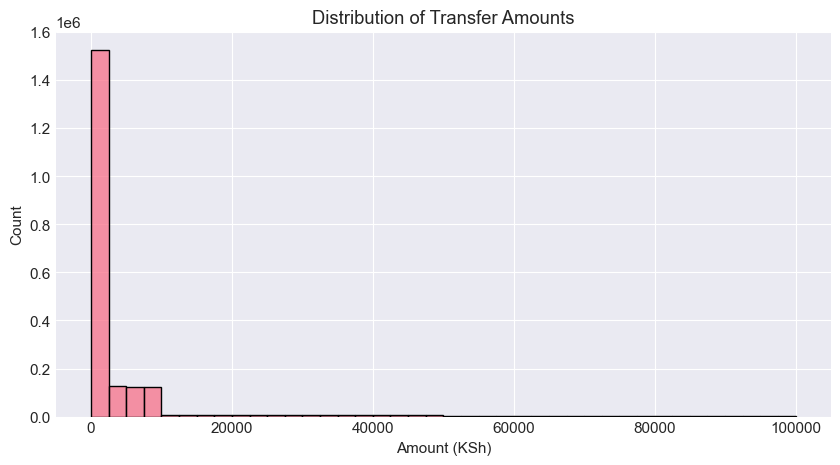

In [34]:
# amount distribution plot
plt.figure(figsize=(10,5))
sns.histplot(full_df['amount'], bins=40, kde=False)
plt.title('Distribution of Transfer Amounts')
plt.xlabel('Amount (KSh)')
plt.show()

## 8.Types of Days/Planners Breakdown

In [35]:
#day_type distribution
full_df['day_type'].value_counts()

day_type
Recovery           780557
Normal Day         615000
Panic Mode         186837
Valentine's Day    174783
Getting Serious    132594
Early Planners     108486
Name: count, dtype: int64

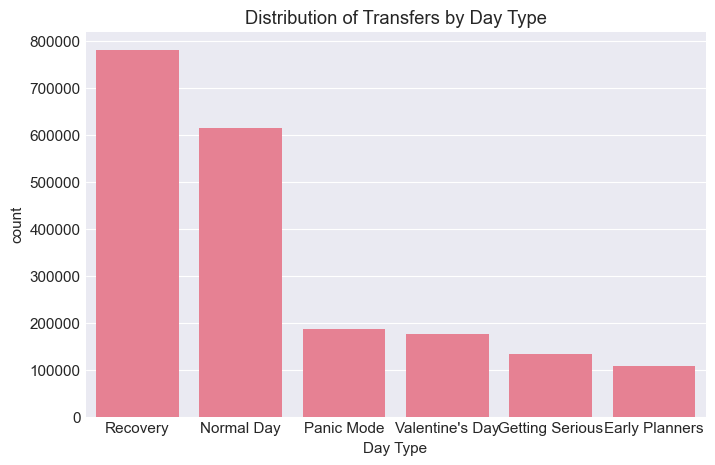

In [36]:
#visualization of day_type breakdwown
plt.figure(figsize=(8,5))
sns.countplot(data=full_df, x='day_type', order=full_df['day_type'].value_counts().index)
plt.title('Distribution of Transfers by Day Type')
plt.xlabel('Day Type')
plt.show()

In [37]:
# Breakdown of amount by day_type
amount_by_daytype = full_df.groupby('day_type').agg({
    'amount': ['count', 'mean', 'sum']
}).round(2)
amount_by_daytype.columns = ['Transaction_Count', 'Mean_Amount', 'Total_Amount']
amount_by_daytype.sort_values('Transaction_Count', ascending=False)

,Transaction_Count,Mean_Amount,Total_Amount
day_type,,,
Recovery,780557,3249.24,2.536218e+09
Normal Day,615000,3249.93,1.998705e+09
Panic Mode,186837,4530.92,8.465439e+08
Valentine's Day,174783,4483.00,7.835516e+08
Getting Serious,132594,4544.22,6.025369e+08
Early Planners,108486,4496.46,4.878026e+08


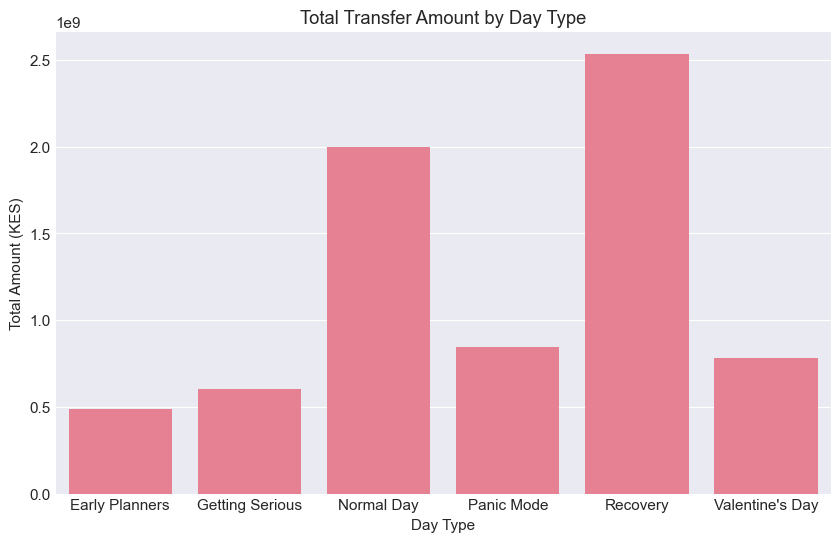

In [38]:
# visualize breakdown of amount by day_type
plt.figure(figsize=(10,6))
sns.barplot(x=amount_by_daytype.index, y=amount_by_daytype['Total_Amount'])
plt.title('Total Transfer Amount by Day Type')  
plt.xlabel('Day Type')
plt.ylabel('Total Amount (KES)')
plt.show()

## 9.Period Breakdown

In [39]:
#period breakdown
period_counts = full_df['period'].value_counts()
period_counts  

period
post_valentine    780557
baseline          615000
valentine         602700
Name: count, dtype: int64

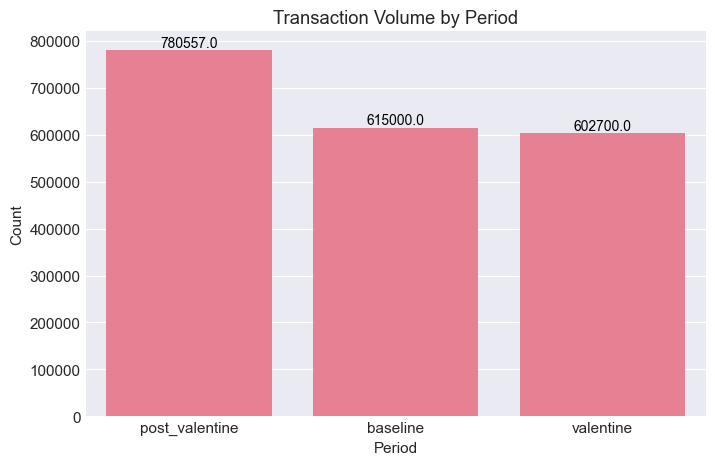

In [40]:
#period breakdown plot
plt.figure(figsize=(8,5))
sns.countplot(data=full_df, x='period', order=period_counts.index)
#adding data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                       textcoords='offset points')  
plt.title('Transaction Volume by Period')
plt.xlabel('Period')    
plt.ylabel('Count')
plt.show()

## 10. Amount Category Comparison: Valentine vs Baseline Spending

### Amount Category Volume Comparison by Period

In [41]:
#amount_category volume comparison by period
amount_category_comparison = full_df.groupby(['amount_category', 'period']).size().unstack(fill_value=0)
amount_category_comparison

period,baseline,post_valentine,valentine
amount_category,,,
big-hearted lovers,30806,39307,13845
big-spender,0,0,9
budget romantics,214956,273039,230716
micro romantics,246043,312269,216597
mid-range sweethearts,123195,155852,124868
ultra-romantic,0,90,16665


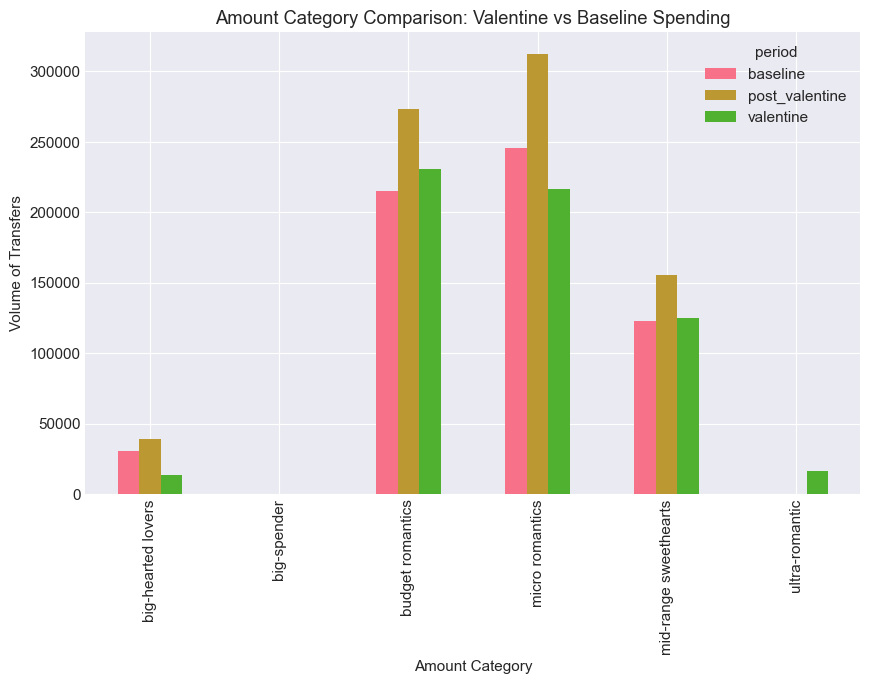

In [42]:
#amount_category comparison by period plot 
amount_category_comparison.plot(kind='bar', figsize=(10,6))
plt.title('Amount Category Comparison: Valentine vs Baseline Spending')
plt.xlabel('Amount Category')
plt.ylabel('Volume of Transfers')
plt.show()

### Amount Category Average Spend Comparison by Period

In [43]:
# amount_category average spend
amount_category_spend = full_df.groupby(['amount_category', 'period'])['amount'].mean().unstack(fill_value=0)
amount_category_spend

period,baseline,post_valentine,valentine
amount_category,,,
big-hearted lovers,29981.381682,29811.626422,29194.616468
big-spender,0.000000,0.000000,100000.000000
budget romantics,1250.179437,1250.023661,1159.207198
micro romantics,274.591090,274.659509,333.599943
mid-range sweethearts,5997.026384,5981.998788,5833.659236
ultra-romantic,0.000000,55921.514778,74839.106188


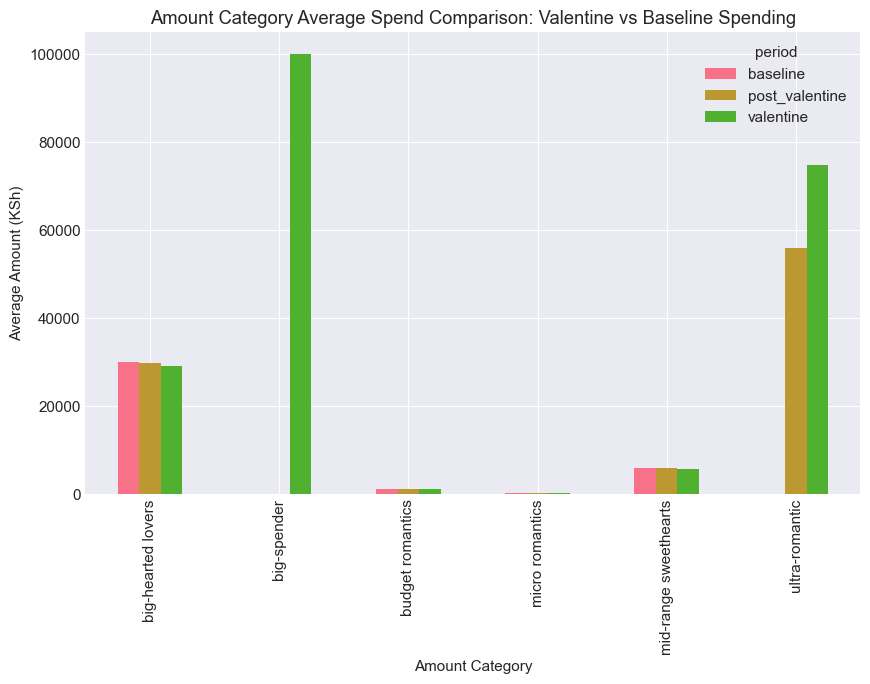

In [44]:
#amount_category average spend plot
amount_category_spend.plot(kind='bar', figsize=(10,6))
plt.title('Amount Category Average Spend Comparison: Valentine vs Baseline Spending')
plt.xlabel('Amount Category')
plt.ylabel('Average Amount (KSh)')
plt.show()

### Amount Category Average Spend (in KES & $) Comparison on Valentine

Here, we are reviewing average love transfer amounts and %(proportion) during valentine for different amount_category personas.

The amount_category personas are as follows:

- micro-romantics: Sending KSh 100-500
- budget romantics: Sending KSh 500-2000 
- mid-range sweethearts: Sending KSh 5000-10000 
- big-hearted lovers: Sending KSh 10000-50000
- ultra-romantic: Sending KSh 50000-10000 
- big-spender: Sending KSh 100,000 and above

In [45]:
# Reviewing average love transfer amounts and %(proportion) during valentine for different amount_category personas
amount_category_spend_valentine = full_df[full_df['period']=='valentine'].groupby('amount_category')['amount'].mean().round(2)
amount_category_proportion_valentine = full_df[full_df['period']=='valentine']['amount_category'].value_counts(normalize=True).round(4) * 100

print(amount_category_spend_valentine) 
print("-"*70)
print(amount_category_proportion_valentine)

amount_category
big-hearted lovers        29194.62
big-spender              100000.00
budget romantics           1159.21
micro romantics             333.60
mid-range sweethearts      5833.66
ultra-romantic            74839.11
Name: amount, dtype: float64
----------------------------------------------------------------------
amount_category
budget romantics         38.28
micro romantics          35.94
mid-range sweethearts    20.72
ultra-romantic            2.77
big-hearted lovers        2.30
big-spender               0.00
Name: proportion, dtype: float64


In [46]:
# Convert to USD (approx 1 USD = 129.70 KSh: exchange rate as of 24th November 2025)
usd_rate = 129
# amount_category_spend_valentine in $ (average amount)
amount_category_spend_valentine_usd = (amount_category_spend_valentine / usd_rate).round(2)
amount_category_spend_valentine_usd

amount_category
big-hearted lovers       226.31
big-spender              775.19
budget romantics           8.99
micro romantics            2.59
mid-range sweethearts     45.22
ultra-romantic           580.15
Name: amount, dtype: float64

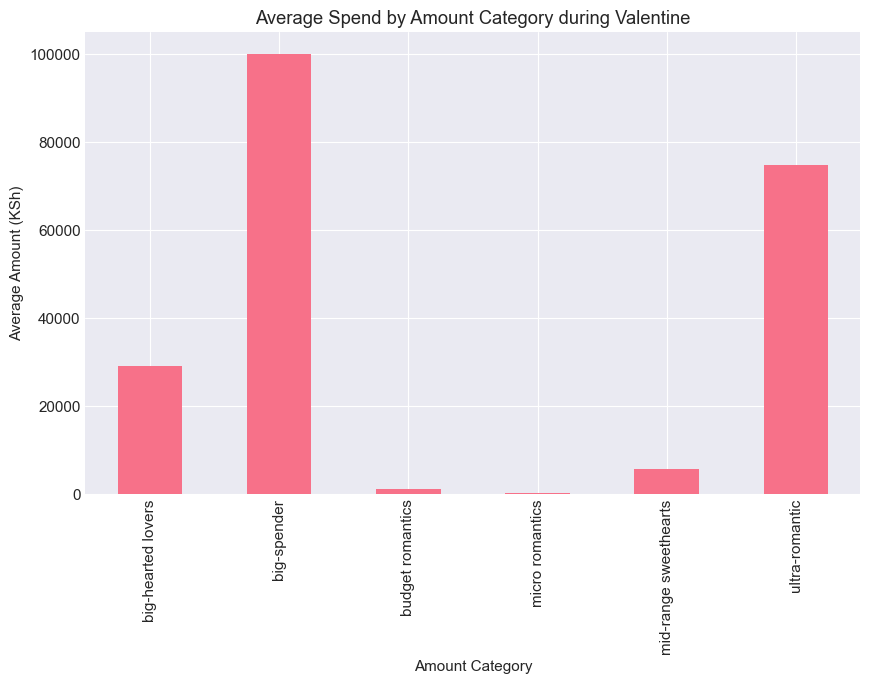

In [47]:
#visualize amount_category_spend_valentine
amount_category_spend_valentine.plot(kind='bar', figsize=(10,6))
plt.title('Average Spend by Amount Category during Valentine')
plt.xlabel('Amount Category')
plt.ylabel('Average Amount (KSh)')
plt.show()

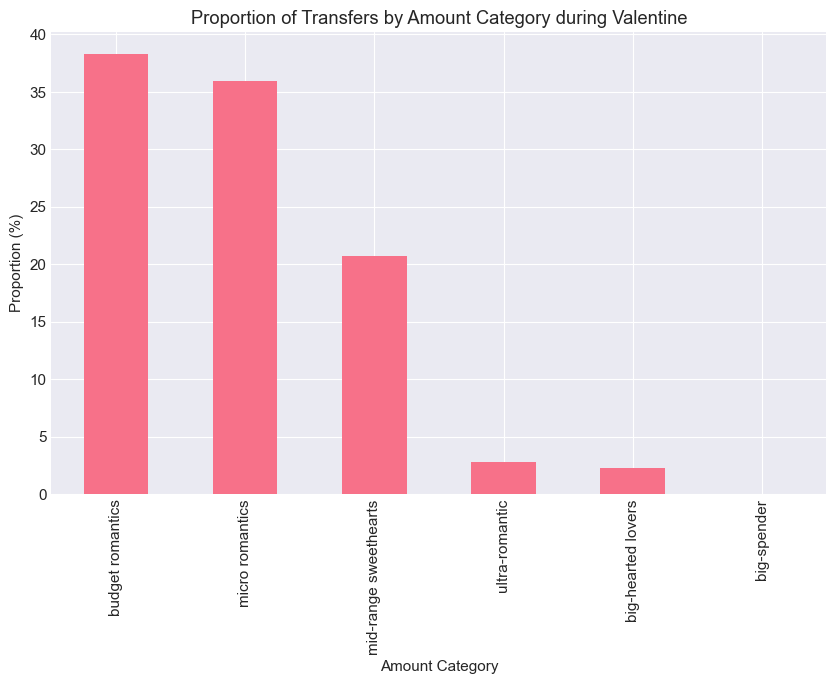

In [48]:
#Visualize amount_category_proportion_valentine
amount_category_proportion_valentine.plot(kind='bar', figsize=(10,6))
plt.title('Proportion of Transfers by Amount Category during Valentine')
plt.xlabel('Amount Category')
plt.ylabel('Proportion (%)')
plt.show()

## 11. Valentine vs Baseline Spend Amount Comparison 

In [49]:
# Valentine's vs Baseline Spend Amount Comparison
valentine_df = full_df[full_df['period'] == 'valentine']
baseline_df = full_df[full_df['period'] == 'baseline']


print("\n2. VALENTINE'S VS BASELINE SPEND AMOUNT COMPARISON")
print("-"*70)
valentine_stats = valentine_df['amount'].describe()
baseline_stats = baseline_df['amount'].describe()

comparison = pd.DataFrame({
    'Baseline (Feb 1-10)': baseline_stats,
    'Valentine\'s (Feb 11-14)': valentine_stats,
    'Difference (%)': ((valentine_stats - baseline_stats) / baseline_stats * 100).round(2)
})
print(comparison)


2. VALENTINE'S VS BASELINE SPEND AMOUNT COMPARISON
----------------------------------------------------------------------
       Baseline (Feb 1-10)  Valentine's (Feb 11-14)  Difference (%)
count        615000.000000            602700.000000           -2.00
mean           3249.926660              4513.746351           38.89
std            7074.419427             13120.129323           85.46
min              50.000000               200.000000          300.00
25%             330.580000               400.000000           21.00
50%             929.535000               906.865000           -2.44
75%            2017.712500              2000.052500           -0.88
max           49999.970000            100000.000000          100.00


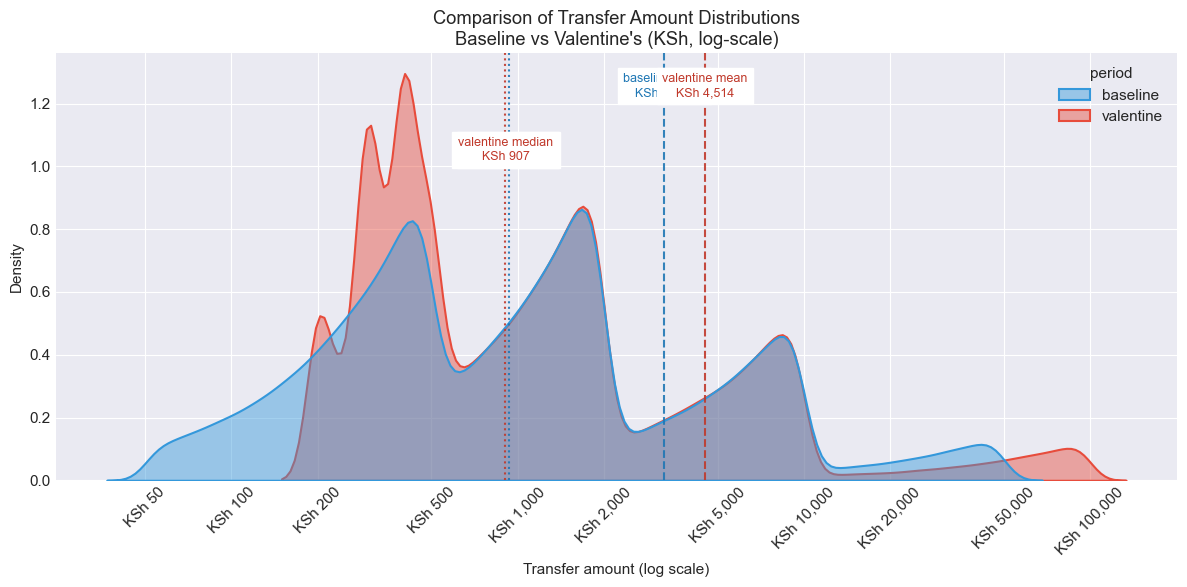

In [50]:
# Visual: KDE on log-scale (clear comparison of distributions)
subset = full_df[full_df['period'].isin(['baseline', 'valentine'])].copy()
subset['log10_amount'] = np.log10(subset['amount'])

plt.figure(figsize=(12,6))
ax = sns.kdeplot(
    data=subset, x='log10_amount', hue='period', fill=True, common_norm=False,
    alpha=0.45, palette=['#3498db', '#e74c3c'], linewidth=1.5
)

# marking means and medians on log scale
for period, color in [('baseline', '#1f77b4'), ('valentine', '#c0392b')]:
    p_data = subset[subset['period'] == period]['amount']
    mean_log = np.log10(p_data.mean())
    med_log = np.log10(p_data.median())
    ax.axvline(mean_log, color=color, linestyle='--', linewidth=1.5, alpha=0.9)
    ax.axvline(med_log, color=color, linestyle=':', linewidth=1.5, alpha=0.9)
    ax.text(mean_log, ax.get_ylim()[1]*0.9, f"{period} mean\nKSh {p_data.mean():,.0f}",
            color=color, ha='center', fontsize=9, backgroundcolor='white')
    ax.text(med_log, ax.get_ylim()[1]*0.75, f"{period} median\nKSh {p_data.median():,.0f}",
            color=color, ha='center', fontsize=9, backgroundcolor='white')

# convert x-axis back to readable KSh ticks
ticks = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
ax.set_xticks(np.log10(ticks))
ax.set_xticklabels([f"KSh {t:,}" for t in ticks], rotation=45)
ax.set_xlabel('Transfer amount (log scale)')
ax.set_ylabel('Density')
ax.set_title("Comparison of Transfer Amount Distributions\nBaseline vs Valentine's (KSh, log-scale)")
plt.tight_layout()
plt.show()


# Analytical Questions

### Quiz 1: Transaction Volume Surge 

In [51]:
print("\n1. VALENTINE'S SURGE ANALYSIS")
print("-"*70)
baseline_daily_avg = len(baseline_df) / 10 #10 days pre-valentine representing baseline period
valentine_daily_avg = len(valentine_df) / 4 #4days representing valentine period

#baseline_daily_avg_per_user vs valentine_daily_avg_per_user
baseline_daily_avg_per_user = baseline_daily_avg / number_of_users
valentine_daily_avg_per_user = valentine_daily_avg / number_of_users
# surge average daily change(%)
surge_percentage = ((valentine_daily_avg - baseline_daily_avg) / baseline_daily_avg) * 100

print(f"Baseline's daily average number of transactions: {baseline_daily_avg:,.0f} transactions")
print(f"Valentine's daily average number of transactions: {valentine_daily_avg:,.0f} transactions")
print(f"Baseline's daily average number of transactions per user: {baseline_daily_avg_per_user:.2f} transactions/user")
print(f"Valentine's daily average number of transactions per user: {valentine_daily_avg_per_user:.2f} transactions/user")
print(f"Surge in volume of transactions (%): {surge_percentage:.1f}%")


1. VALENTINE'S SURGE ANALYSIS
----------------------------------------------------------------------
Baseline's daily average number of transactions: 61,500 transactions
Valentine's daily average number of transactions: 150,675 transactions
Baseline's daily average number of transactions per user: 1.23 transactions/user
Valentine's daily average number of transactions per user: 3.01 transactions/user
Surge in volume of transactions (%): 145.0%


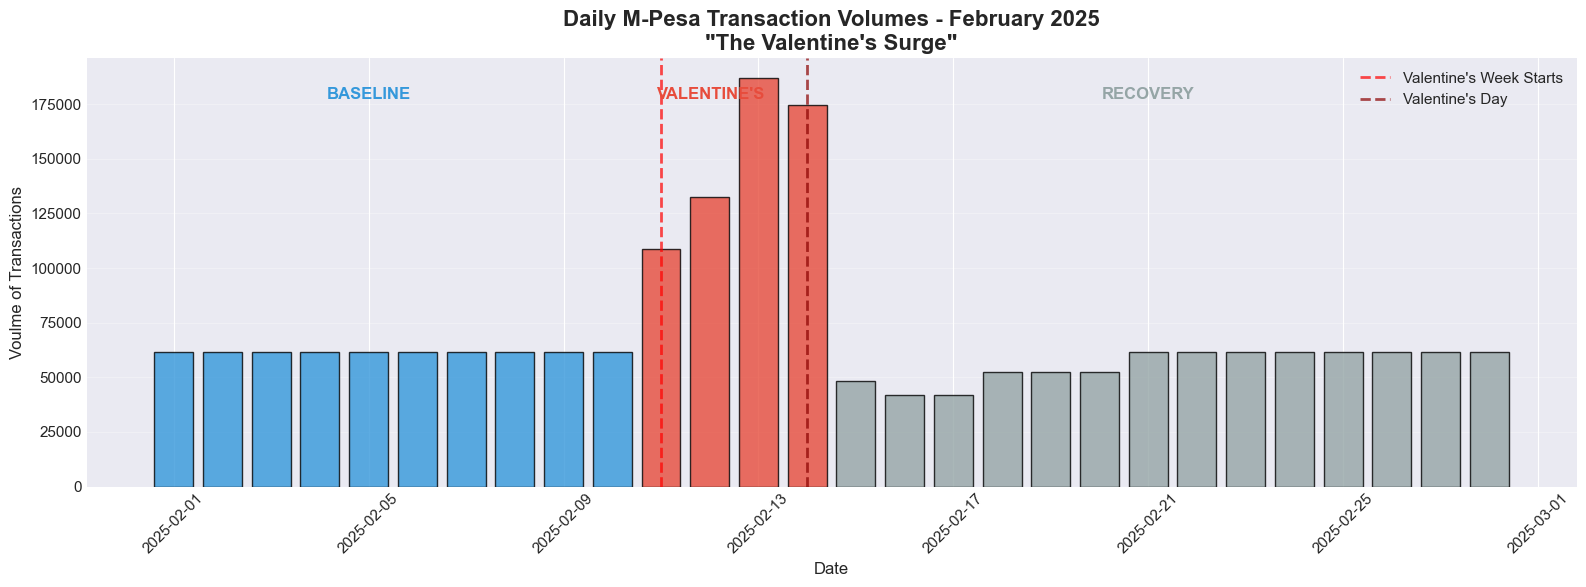

✓ Saved: valentine_daily_volumes.png


In [52]:
# Visualization 1: Daily transaction volumes throughout February
fig, ax = plt.subplots(figsize=(16, 6))
daily_counts = full_df.groupby('date').size()
colors = ['#3498db' if d.day < 11 else '#e74c3c' if d.day <= 14 else '#95a5a6' 
          for d in daily_counts.index]

ax.bar(daily_counts.index, daily_counts.values, color=colors, alpha=0.8, edgecolor='black')
ax.axvline(datetime(2025, 2, 11), color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label='Valentine\'s Week Starts')
ax.axvline(datetime(2025, 2, 14), color='darkred', linestyle='--', linewidth=2, alpha=0.7, 
           label='Valentine\'s Day')

ax.set_title('Daily M-Pesa Transaction Volumes - February 2025\n"The Valentine\'s Surge"', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Voulme of Transactions', fontsize=12)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add period labels
ax.text(datetime(2025, 2, 5), daily_counts.max() * 0.95, 'BASELINE', 
        fontsize=12, ha='center', color='#3498db', fontweight='bold')
ax.text(datetime(2025, 2, 12), daily_counts.max() * 0.95, 'VALENTINE\'S', 
        fontsize=12, ha='center', color='#e74c3c', fontweight='bold')
ax.text(datetime(2025, 2, 21), daily_counts.max() * 0.95, 'RECOVERY', 
        fontsize=12, ha='center', color='#95a5a6', fontweight='bold')

# Saving the chart
fig.savefig('valentine_daily_volumes.png', dpi=300, bbox_inches='tight')

plt.xticks(rotation=45)
plt.tight_layout()

# display in Jupyter and confirm save
display(fig)
print("✓ Saved: valentine_daily_volumes.png")

plt.close(fig)


## Quiz 2: Amount Distributed by Period

In [53]:
# Amount distribution by period
print("\n2. AMOUNT DISTRIBUTION BY PERIOD")
print("-"*70)
for period in ['baseline', 'valentine', 'post_valentine']:
    period_data = full_df[full_df['period'] == period]['amount']
    print(f"\n{period.upper()}:")
    print(f"  Mean: KSh {period_data.mean():,.2f}")
    print(f"  Total Sum: KSh {period_data.sum():,.2f}")
    print(f"  Median: KSh {period_data.median():,.2f}")
    print(f"  Mode: KSh {period_data.mode()[0]:,.2f}")
    print(f"  Std Dev: KSh {period_data.std():,.2f}")


2. AMOUNT DISTRIBUTION BY PERIOD
----------------------------------------------------------------------

BASELINE:
  Mean: KSh 3,249.93
  Total Sum: KSh 1,998,704,896.10
  Median: KSh 929.53
  Mode: KSh 80.23
  Std Dev: KSh 7,074.42

VALENTINE:
  Mean: KSh 4,513.75
  Total Sum: KSh 2,720,434,925.93
  Median: KSh 906.87
  Mode: KSh 400.00
  Std Dev: KSh 13,120.13

POST_VALENTINE:
  Mean: KSh 3,249.24
  Total Sum: KSh 2,536,217,871.98
  Median: KSh 928.80
  Mode: KSh 390.46
  Std Dev: KSh 7,088.33


In [54]:
# Amount distribution by period in usd
print("\n3. AMOUNT DISTRIBUTION BY PERIOD IN USD")
print("-"*70)
for period in ['baseline', 'valentine', 'post_valentine']:
    period_data = full_df[full_df['period'] == period]['amount'] / usd_rate
    print(f"\n{period.upper()}:")
    print(f"  Mean: $ {period_data.mean():,.2f}")
    print(f"  Total Sum: $ {period_data.sum():,.2f}")
    print(f"  Median: $ {period_data.median():,.2f}")
    print(f"  Mode: $ {period_data.mode()[0]:,.2f}")
    print(f"  Std Dev: $ {period_data.std():,.2f}")


3. AMOUNT DISTRIBUTION BY PERIOD IN USD
----------------------------------------------------------------------

BASELINE:
  Mean: $ 25.19
  Total Sum: $ 15,493,836.40
  Median: $ 7.21
  Mode: $ 0.62
  Std Dev: $ 54.84

VALENTINE:
  Mean: $ 34.99
  Total Sum: $ 21,088,642.84
  Median: $ 7.03
  Mode: $ 3.10
  Std Dev: $ 101.71

POST_VALENTINE:
  Mean: $ 25.19
  Total Sum: $ 19,660,603.66
  Median: $ 7.20
  Mode: $ 3.03
  Std Dev: $ 54.95


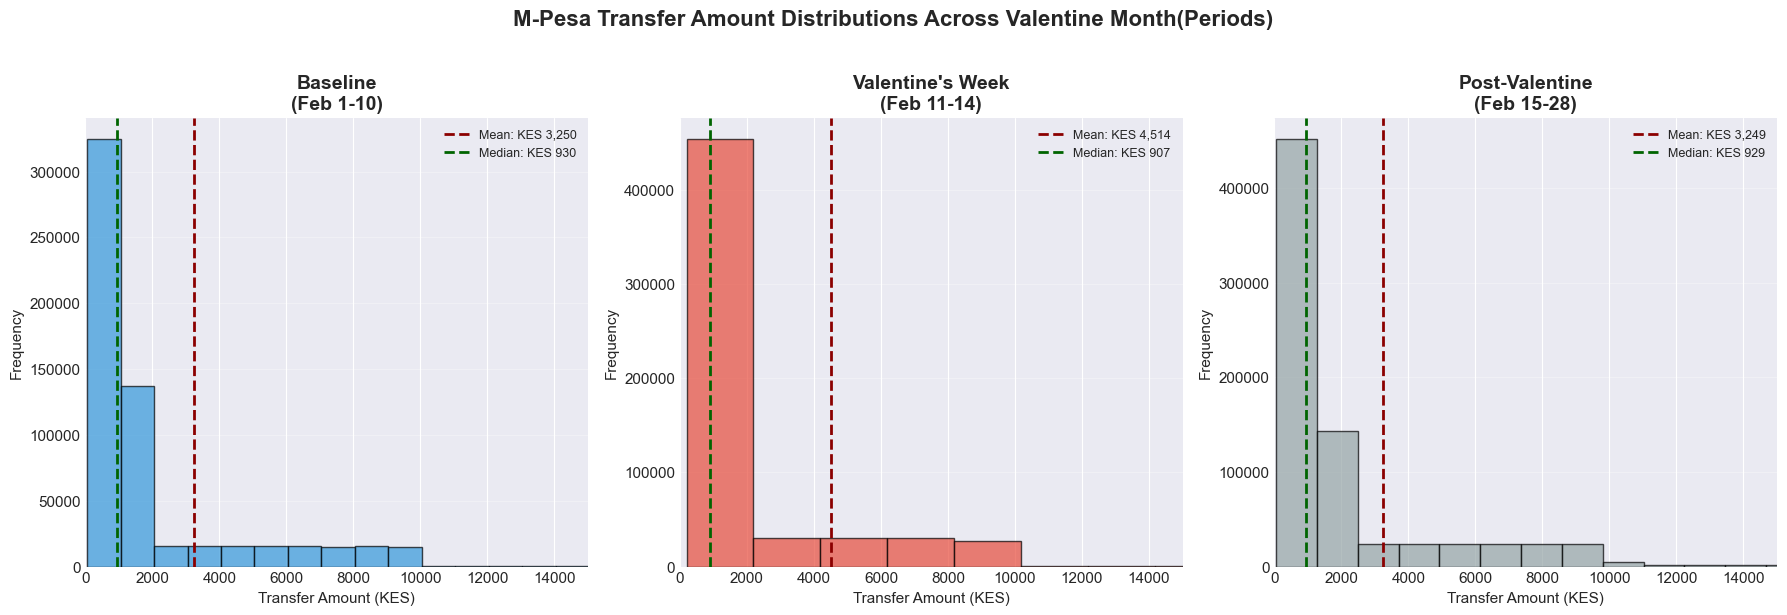

✓ Saved: amount_distributions.png


In [55]:
# Visualization 2: Amount distribution by period
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
periods = ['baseline', 'valentine', 'post_valentine']
titles = ['Baseline\n(Feb 1-10)', 'Valentine\'s Week\n(Feb 11-14)', 'Post-Valentine\n(Feb 15-28)']
colors_hist = ['#3498db', '#e74c3c', '#95a5a6']

for idx, (period, title, color) in enumerate(zip(periods, titles, colors_hist)):
    period_amounts = full_df[full_df['period'] == period]['amount']
    
    axes[idx].hist(period_amounts, bins=50, color=color, alpha=0.7, edgecolor='black')
    axes[idx].axvline(period_amounts.mean(), color='darkred', linestyle='--', 
                      linewidth=2, label=f'Mean: KES {period_amounts.mean():,.0f}')
    axes[idx].axvline(period_amounts.median(), color='darkgreen', linestyle='--', 
                      linewidth=2, label=f'Median: KES {period_amounts.median():,.0f}')
    
    axes[idx].set_title(title, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Transfer Amount (KES)', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].legend(fontsize=9)
    axes[idx].set_xlim(0, 15000)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('M-Pesa Transfer Amount Distributions Across Valentine Month(Periods)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
plt.savefig('amount_distributions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: amount_distributions.png")
plt.close()



## Quiz 3:Gender Pattern Analysis on Valentine's Day

In [56]:
# Gender pattern analysis (Valentine's only)
print("\n3. GENDER PATTERN ANALYSIS (VALENTINE'S)")
print("-"*70)
gender_analysis = valentine_df.groupby('gender_pattern').agg({
    'amount': ['count', 'mean', 'sum']
}).round(2)
gender_analysis.columns = ['Count', 'Avg_Amount_KSh', 'Total_Value_KSh']
gender_analysis['Percentage'] = (gender_analysis['Count'] / len(valentine_df) * 100).round(2)
print(gender_analysis.sort_values('Count', ascending=False))


3. GENDER PATTERN ANALYSIS (VALENTINE'S)
----------------------------------------------------------------------
                   Count  Avg_Amount_KSh  Total_Value_KSh  Percentage
gender_pattern                                                       
Male_to_Female    373590         4505.39     1.683170e+09       61.99
Female_to_Male    168885         4524.45     7.641112e+08       28.02
Female to_Female   36100         4564.44     1.647761e+08        5.99
Male_to_Male       24125         4492.34     1.083777e+08        4.00


✓ Saved: gender_analysis.png


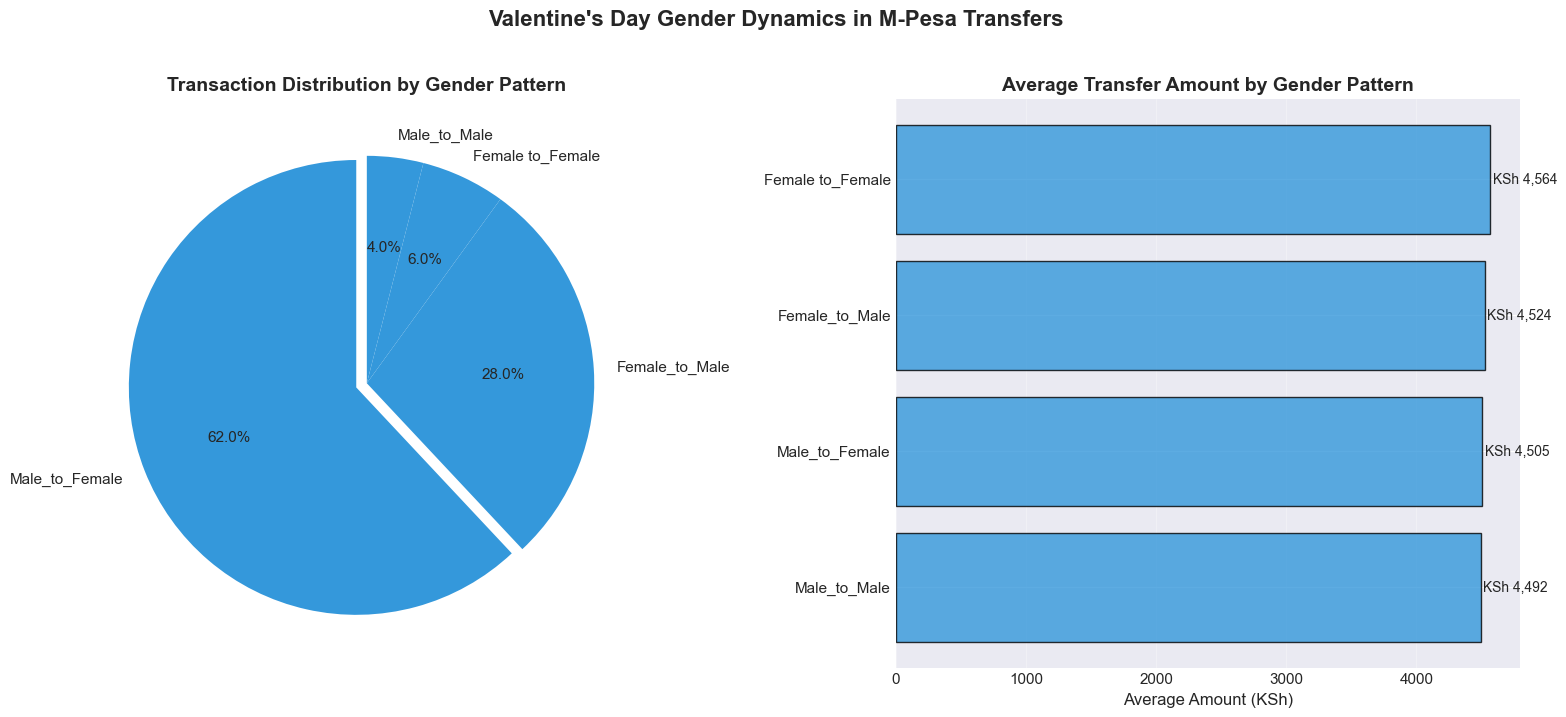

In [57]:
# Visualization 3: Gender pattern comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Count comparison
gender_counts = valentine_df['gender_pattern'].value_counts()
n_cats = len(gender_counts)

# Build a safe color palette (choose existing one or fallback)
# Use colors_gender if defined; otherwise fall back to 'colors' or a default list.
_colors_source = globals().get('colors_gender') or globals().get('colors') or ['#e74c3c', '#3498db', '#95a5a6', '#9b59b6', '#f39c12']
colors_palette = list(_colors_source)[:n_cats]

# explode must match number of wedges
explode = [0.05] + [0] * (n_cats - 1)

ax1.pie(
    gender_counts.values,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_palette,
    explode=explode
)
ax1.set_title('Transaction Distribution by Gender Pattern', fontsize=14, fontweight='bold')

# Amount comparison
gender_amounts = (
    valentine_df.groupby('gender_pattern')['amount']
    .mean()
    .sort_values(ascending=True)
)

ax2.barh(
    y=range(len(gender_amounts)),
    width=gender_amounts.values,
    color=colors_palette[:len(gender_amounts)],
    alpha=0.8,
    edgecolor='black'
)

ax2.set_yticks(range(len(gender_amounts)))
ax2.set_yticklabels(gender_amounts.index)
ax2.set_xlabel('Average Amount (KSh)', fontsize=12)
ax2.set_title('Average Transfer Amount by Gender Pattern', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Annotate bars
for i, val in enumerate(gender_amounts.values):
    ax2.text(val + 20, i, f'KSh {val:,.0f}', va='center', fontsize=10)

# Main title
plt.suptitle(
    "Valentine's Day Gender Dynamics in M-Pesa Transfers",
    fontsize=16,
    fontweight='bold',
    y=1.02
)
plt.tight_layout()

# Saving figure
plt.savefig('gender_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: gender_analysis.png")

plt.show()
plt.close()


## Quiz 4. County Performance during Valentine Analysis

In [58]:
#County performance analysis (Valentine's only)
print("\n4. GEOGRAPHIC DISTRIBUTION (VALENTINE'S)")
print("-"*70)
county_analysis = valentine_df.groupby('county').agg({
    'amount': ['count', 'mean', 'sum']
}).round(2)
county_analysis.columns = ['Count', 'Avg_Amount_KES', 'Total_Value_KES']
county_analysis['Percentage'] = (county_analysis['Count'] / len(valentine_df) * 100).round(2) #rank by volume(Count) of transactions
county_analysis.sort_values('Count', ascending=False)


4. GEOGRAPHIC DISTRIBUTION (VALENTINE'S)
----------------------------------------------------------------------


,Count,Avg_Amount_KES,Total_Value_KES,Percentage
county,,,,
Nairobi,204396,4530.28,9.259718e+08,33.91
Mombasa,72635,4533.65,3.293020e+08,12.05
Kiambu,60274,4505.85,2.715854e+08,10.00
Kilifi,60160,4532.79,2.726925e+08,9.98
Narok,47956,4419.85,2.119586e+08,7.96
Nakuru,42276,4456.99,1.884236e+08,7.01
Kisumu,30216,4468.65,1.350249e+08,5.01
Kajiado,24243,4578.23,1.109900e+08,4.02
Uasin Gishu,18120,4614.39,8.361269e+07,3.01


✓ Saved: county_distribution.png


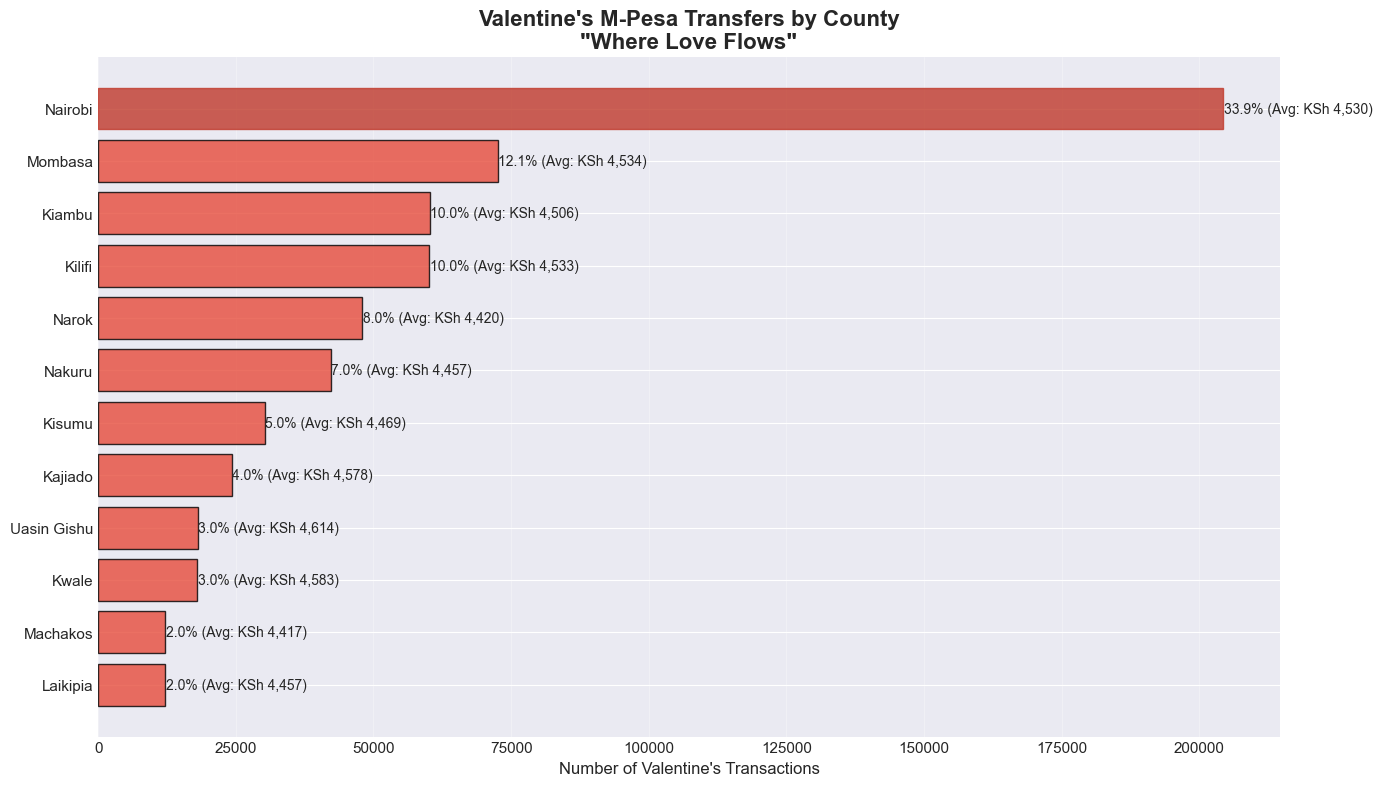

In [59]:
# Visualization 4: County comparison
fig, ax = plt.subplots(figsize=(14, 8))
county_data = valentine_df.groupby('county').agg({
    'amount': ['count', 'mean']
}).round(2)
county_data.columns = ['count', 'mean']
county_data = county_data.sort_values('count', ascending=True)

y_pos = np.arange(len(county_data))
bars = ax.barh(y_pos, county_data['count'], color='#e74c3c', alpha=0.8, edgecolor='black')

# Highlight Nairobi
bars[list(county_data.index).index('Nairobi')].set_color('#c0392b')

ax.set_yticks(y_pos)
ax.set_yticklabels(county_data.index, fontsize=11)
ax.set_xlabel('Number of Valentine\'s Transactions', fontsize=12)
ax.set_title('Valentine\'s M-Pesa Transfers by County\n"Where Love Flows"', 
             fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (count, mean) in enumerate(zip(county_data['count'], county_data['mean'])):
    percentage = (count / valentine_df.shape[0] * 100)
    ax.text(count + 50, i, f'{percentage:.1f}% (Avg: KSh {mean:,.0f})', 
            va='center', fontsize=10)

plt.tight_layout()

plt.savefig('county_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: county_distribution.png")
plt.show()
plt.close()

## Quiz 5: Urban vs Rural Comparison

In [60]:
# Urban vs Rural comparison (Valentine's only)
print("\n5. URBAN VS RURAL COMPARISON (VALENTINE'S)")
print("-"*70)
location_analysis = valentine_df.groupby('location_type').agg({
    'amount': ['count', 'mean', 'median', 'sum']
}).round(2)
location_analysis.columns = ['Count', 'Avg_Amount_KSh', 'Median_Amount_KSh', 'Total_Value_KSh']
print(location_analysis)


5. URBAN VS RURAL COMPARISON (VALENTINE'S)
----------------------------------------------------------------------
                Count  Avg_Amount_KSh  Median_Amount_KSh  Total_Value_KSh
location_type                                                            
Rural          235057         4501.46             903.27     1.058100e+09
Urban          367643         4521.60             909.09     1.662335e+09


✓ Saved: urban_rural_comparison.png


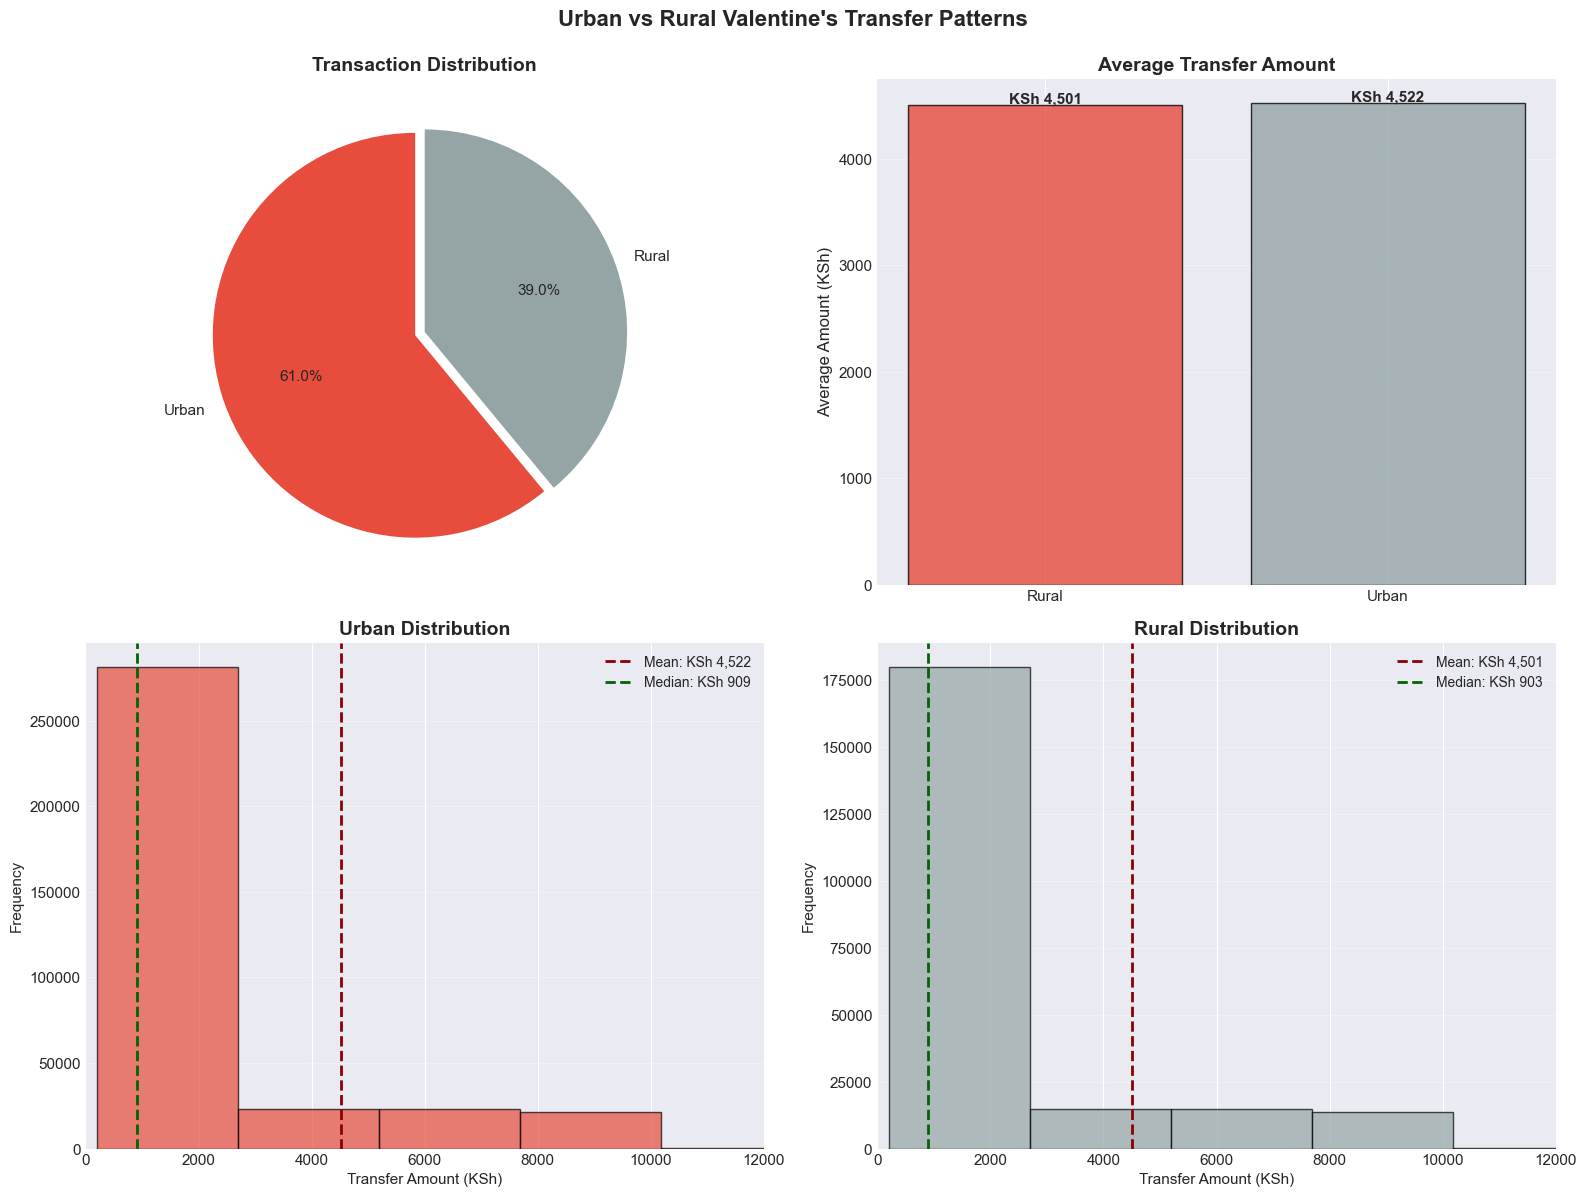

In [61]:
# Visualization 5: Urban vs Rural comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Transaction count
location_counts = valentine_df['location_type'].value_counts()
axes[0, 0].pie(location_counts.values, labels=location_counts.index, autopct='%1.1f%%', 
               startangle=90, colors=['#e74c3c', '#95a5a6'], explode=[0.05, 0])
axes[0, 0].set_title('Transaction Distribution', fontsize=14, fontweight='bold')

# Average amounts
location_means = valentine_df.groupby('location_type')['amount'].mean()
bars = axes[0, 1].bar(location_means.index, location_means.values, 
                      color=['#e74c3c', '#95a5a6'], alpha=0.8, edgecolor='black')
axes[0, 1].set_ylabel('Average Amount (KSh)', fontsize=12)
axes[0, 1].set_title('Average Transfer Amount', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for bar, val in zip(bars, location_means.values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, val + 20, 
                    f'KSh {val:,.0f}', ha='center', fontsize=11, fontweight='bold')

# Amount distribution
for idx, location in enumerate(['Urban', 'Rural']):
    location_data = valentine_df[valentine_df['location_type'] == location]['amount']
    color = '#e74c3c' if location == 'Urban' else '#95a5a6'
    
    axes[1, idx].hist(location_data, bins=40, color=color, alpha=0.7, edgecolor='black')
    axes[1, idx].axvline(location_data.mean(), color='darkred', linestyle='--', 
                         linewidth=2, label=f'Mean: KSh {location_data.mean():,.0f}')
    axes[1, idx].axvline(location_data.median(), color='darkgreen', linestyle='--', 
                         linewidth=2, label=f'Median: KSh {location_data.median():,.0f}')
    
    axes[1, idx].set_title(f'{location} Distribution', fontsize=14, fontweight='bold')
    axes[1, idx].set_xlabel('Transfer Amount (KSh)', fontsize=11)
    axes[1, idx].set_ylabel('Frequency', fontsize=11)
    axes[1, idx].legend(fontsize=10)
    axes[1, idx].set_xlim(0, 12000)
    axes[1, idx].grid(axis='y', alpha=0.3)

plt.suptitle('Urban vs Rural Valentine\'s Transfer Patterns', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('urban_rural_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: urban_rural_comparison.png")

plt.show()
plt.close()

## Quiz 6: Temporal Analysis: Time of Day Analysis (Valentine's Day)

In [62]:
 # Time-of-day analysis for Valentine's Day
print("\n6. VALENTINE'S DAY (FEB 14) HOURLY PATTERN")
print("-"*70)
feb14_data = valentine_df[valentine_df['date'] == datetime(2025, 2, 14)]
hourly_pattern = feb14_data.groupby('hour').agg({
    'amount': ['count', 'mean', 'sum', 'median','max']
}).round(2)
hourly_pattern.columns = ['Transaction_Count', 'Avg_Amount_KES', 'Total_Value_KES', 'Median_Amount_KES', 'Max_Amount_KES']
hourly_pattern['Percentage_of_Day'] = (hourly_pattern['Transaction_Count'] / 
                                        len(feb14_data) * 100).round(2)
hourly_pattern.sort_values('Transaction_Count', ascending=False)


6. VALENTINE'S DAY (FEB 14) HOURLY PATTERN
----------------------------------------------------------------------


,Transaction_Count,Avg_Amount_KES,Total_Value_KES,Median_Amount_KES,Max_Amount_KES,Percentage_of_Day
hour,,,,,,
13,14702,4571.78,67214368.98,900.00,100000.00,8.41
19,14700,4566.16,67122612.66,900.00,100000.00,8.41
18,13215,4504.62,59528535.76,1000.00,99900.00,7.56
14,13145,4389.04,57693899.30,904.89,99959.77,7.52
8,11686,4468.36,52217300.20,900.00,99982.00,6.69
12,11628,4492.91,52243527.02,900.00,99900.00,6.65
20,11622,4549.17,52870486.04,993.18,99800.00,6.65
7,10382,4407.77,45761436.61,900.00,99944.48,5.94
17,10277,4422.67,45451775.47,924.82,99500.00,5.88


In [63]:
feb14_data.head()

,date,hour,amount,county,location_type,gender_pattern,message_type,day_type,is_serial_romantic,relationship_status,event_type,is_valentine_related,period,is_apology,amount_category
1042917,2025-02-14,15,3700.00,Mombasa,Urban,Male_to_Female,Emergency Valentines for You,Valentine's Day,False,Long-Term/Spouse,Transport/Uber,True,valentine,False,mid-range sweethearts
1042918,2025-02-14,3,3900.00,Nairobi,Urban,Female_to_Male,Happy Valentines ❤️,Valentine's Day,False,Hookup,Dinner,True,valentine,False,mid-range sweethearts
1042919,2025-02-14,15,1300.00,Nairobi,Urban,Female_to_Male,Ya maua na keki,Valentine's Day,False,Long-Term/Spouse,Transport/Uber,True,valentine,False,budget romantics
1042920,2025-02-14,14,2410.00,Nairobi,Urban,Male_to_Male,Ni confirmed! ❤️,Valentine's Day,False,Long-Term/Spouse,Drinks & Clubbing,True,valentine,False,mid-range sweethearts
1042921,2025-02-14,12,581.46,Narok,Rural,Male_to_Female,Happy Valentines ❤️,Valentine's Day,False,Dating,Dinner,True,valentine,False,budget romantics


                           Period  Start_hour  End_hour  Count  Percentage  Average_Amount_KSh
        Morning Surprise (7-9 AM)           7         9  86941       14.43             4464.42
Lunch Hour Declarations (12-2 PM)          12        14 111425       18.49             4532.11
         Evening Romance (5-8 PM)          17        20 189535       31.45             4526.12
 Last Minute Redemption (9-11 PM)          21        23  65606       10.89             4524.26


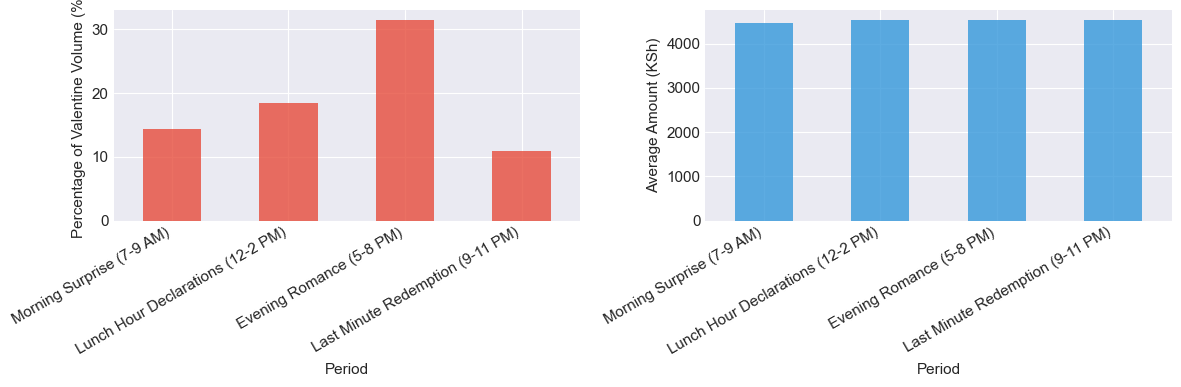

In [64]:
#-- Valentines Hourly Patterns Behaviour: Volume and Average Amount Transfers--
# Using existing `valentine_df` and `time_windows` variables 

windows = globals().get('time_windows', {
    'Morning Surprise (7-9 AM)': (7, 9),
    'Lunch Hour Declarations (12-2 PM)': (12, 14),
    'Evening Romance (5-8 PM)': (17, 20),
    'Last Minute Redemption (9-11 PM)': (21, 23)
})

rows = []
total = len(valentine_df)
for label, (start, end) in windows.items():
    mask = valentine_df['hour'].between(start, end)
    count = int(mask.sum())
    pct = (count / total * 100) if total > 0 else 0.0
    avg_amount = valentine_df.loc[mask, 'amount'].mean()
    rows.append({
        'Period': label,
        'Start_hour': start,
        'End_hour': end,
        'Count': count,
        'Percentage': round(pct, 2),
        'Average_Amount_KSh': round(avg_amount, 2) if not np.isnan(avg_amount) else 0.0
    })

time_window_stats_df = pd.DataFrame(rows)

# Displaying concise summary
print(time_window_stats_df.to_string(index=False))

# Visualization  of the two above computations 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
time_window_stats_df.plot(kind='bar', x='Period', y='Percentage', ax=ax1, legend=False, color='#e74c3c', alpha=0.8)
ax1.set_ylabel('Percentage of Valentine Volume (%)')
ax1.set_xticklabels(time_window_stats_df['Period'], rotation=30, ha='right')

time_window_stats_df.plot(kind='bar', x='Period', y='Average_Amount_KSh', ax=ax2, legend=False, color='#3498db', alpha=0.8)
ax2.set_ylabel('Average Amount (KSh)')
ax2.set_xticklabels(time_window_stats_df['Period'], rotation=30, ha='right')

plt.tight_layout()
plt.show()

✓ Saved: valentine_hourly_pattern.png


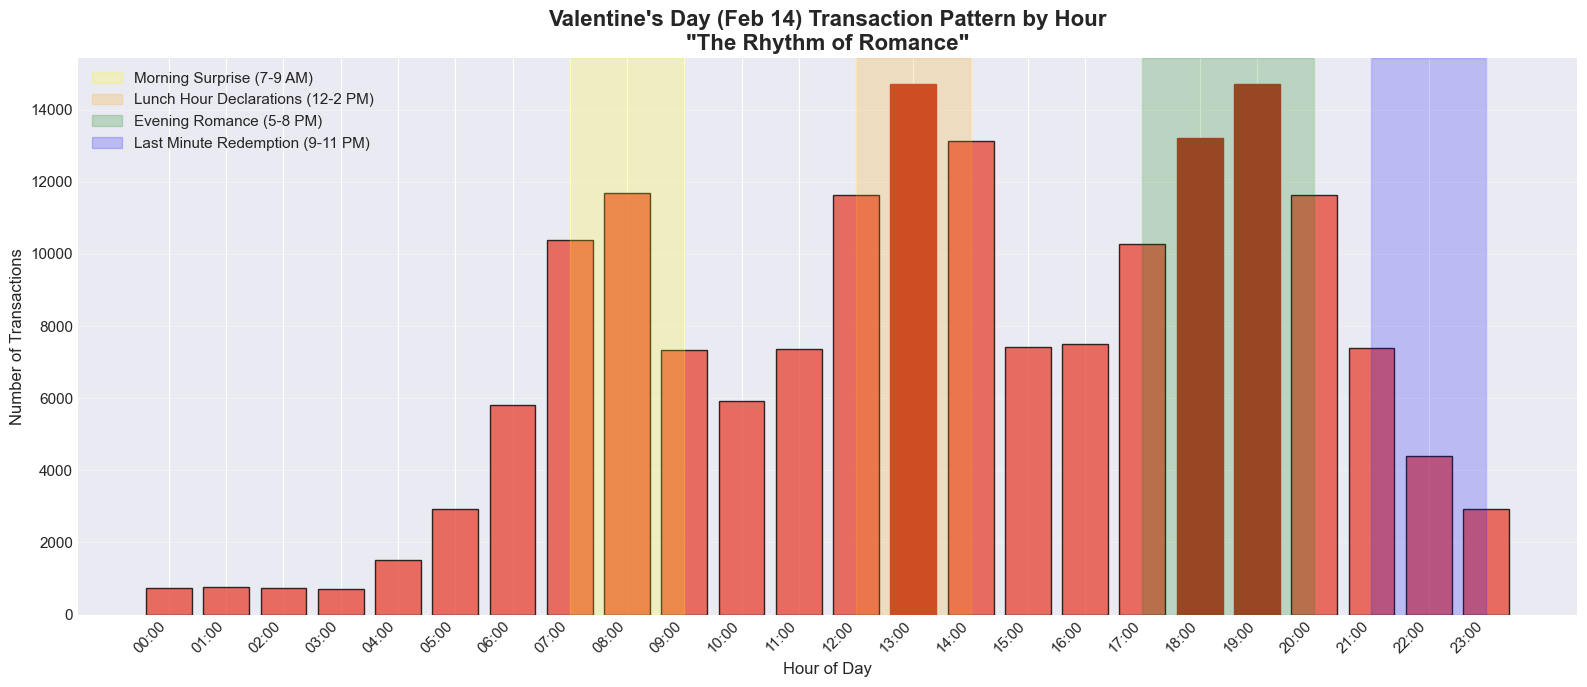

In [65]:
# Visualization 6: Valentine's Day hourly pattern
fig, ax = plt.subplots(figsize=(16, 7))

feb14_hourly = feb14_data.groupby('hour').size()

bars = ax.bar(feb14_hourly.index, feb14_hourly.values, color='#e74c3c', 
              alpha=0.8, edgecolor='black')

# Highlight peak hours
peak_hours = feb14_hourly.nlargest(3).index
for hour in peak_hours:
    bars[hour].set_color('#c0392b')
    bars[hour].set_alpha(1.0)

ax.set_title('Valentine\'s Day (Feb 14) Transaction Pattern by Hour\n"The Rhythm of Romance"', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Transactions', fontsize=12)
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add time period labels
ax.axvspan(7, 9, alpha=0.2, color='yellow', label='Morning Surprise (7-9 AM)')
ax.axvspan(12, 14, alpha=0.2, color='orange', label='Lunch Hour Declarations (12-2 PM)')
ax.axvspan(17, 20, alpha=0.2, color='green', label='Evening Romance (5-8 PM)')
ax.axvspan(21, 23, alpha=0.2, color='blue', label='Last Minute Redemption (9-11 PM)')
ax.legend(fontsize=11, loc='upper left')
plt.tight_layout()

plt.savefig('valentine_hourly_pattern.png', dpi=300, bbox_inches='tight')
print("✓ Saved: valentine_hourly_pattern.png")
plt.show()
plt.close()

###  Peak Hour(s) Identification during Valentine's week

In [66]:
# Peak hour identification during Valentine's week
print("\n7. PEAK TRANSACTION HOURS (ALL VALENTINE'S WEEK)")
print("-"*70)
hourly_valentine = valentine_df.groupby('hour').agg({
    'amount': ['count', 'mean', 'sum']
}).round(2)
hourly_valentine.columns = ['count', 'mean', 'total']
hourly_valentine = hourly_valentine.sort_values('count', ascending=False)

print("Top 5 busiest hours:")
for idx, (hour, row) in enumerate(hourly_valentine.head().iterrows(), 1):
    print(f"  {idx}. {hour:02d}:00 - {int(row['count']):,} transactions | Avg: KSh {row['mean']:,.2f} | Total: KSh {row['total']:,.2f}")

print("\nTop 5 highest-value hours (by average):")
hourly_by_mean = hourly_valentine.sort_values('mean', ascending=False)
for idx, (hour, row) in enumerate(hourly_by_mean.head().iterrows(), 1):
    print(f"  {idx}. {hour:02d}:00 - Avg: KSh {row['mean']:,.2f} | Count: {int(row['count']):,} | Total: KSh {row['total']:,.2f}")



7. PEAK TRANSACTION HOURS (ALL VALENTINE'S WEEK)
----------------------------------------------------------------------
Top 5 busiest hours:
  1. 19:00 - 56,416 transactions | Avg: KSh 4,597.76 | Total: KSh 259,387,232.14
  2. 18:00 - 51,858 transactions | Avg: KSh 4,475.67 | Total: KSh 232,099,416.91
  3. 20:00 - 41,882 transactions | Avg: KSh 4,529.30 | Total: KSh 189,696,037.21
  4. 12:00 - 39,673 transactions | Avg: KSh 4,579.54 | Total: KSh 181,684,267.16
  5. 17:00 - 39,379 transactions | Avg: KSh 4,486.55 | Total: KSh 176,675,658.08

Top 5 highest-value hours (by average):
  1. 00:00 - Avg: KSh 4,976.36 | Count: 3,871 | Total: KSh 19,263,487.54
  2. 23:00 - Avg: KSh 4,725.17 | Count: 14,196 | Total: KSh 67,078,565.03
  3. 16:00 - Avg: KSh 4,675.37 | Count: 27,153 | Total: KSh 126,950,196.04
  4. 19:00 - Avg: KSh 4,597.76 | Count: 56,416 | Total: KSh 259,387,232.14
  5. 12:00 - Avg: KSh 4,579.54 | Count: 39,673 | Total: KSh 181,684,267.16


## Quiz 7:Message Type Distribution

In [67]:
# Message type analysis (Valentine's only)
print("\n7. VALENTINE'S MESSAGE TYPES")
print("-"*70)
message_analysis = valentine_df.groupby('message_type').agg({
    'amount': ['count', 'mean']
}).round(2)
message_analysis.columns = ['Count', 'Avg_Amount_KES']
message_analysis['Percentage'] = (message_analysis['Count'] / len(valentine_df) * 100).round(2)
message_analysis.sort_values('Count', ascending=False)



7. VALENTINE'S MESSAGE TYPES
----------------------------------------------------------------------


,Count,Avg_Amount_KES,Percentage
message_type,,,
Happy Valentines ❤️,108663,4561.14,18.03
Hii ni ya lunch babe,90321,4442.36,14.99
Nakupenda sana 💕,72356,4448.70,12.01
Dinner & surprise,60172,4503.16,9.98
Ya maua na keki,54139,4585.92,8.98
"Tuende Out kesho for Val. Nimetumaya Uber, meet at 7 hapo Kempinski",48445,4489.48,8.04
Emergency Valentines for You,42230,4485.16,7.01
Happy Mens Conference 🍻,36235,4592.02,6.01
Iko nini Baby Girl? Check your Mpesa,30079,4549.24,4.99


✓ Saved: message_types.png


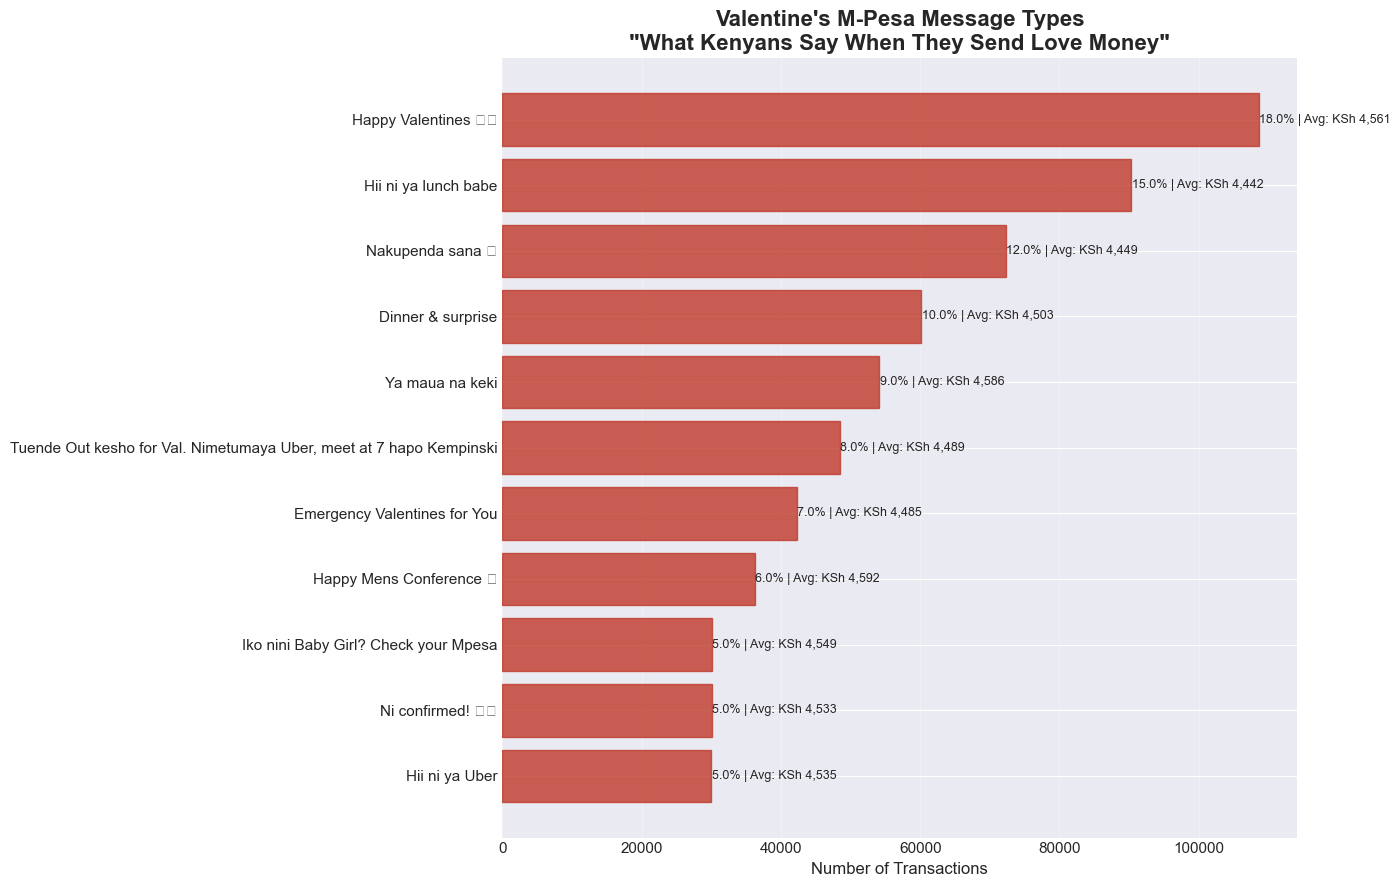

In [68]:
# Visualization 7: Message type analysis
fig, ax = plt.subplots(figsize=(14, 9))
message_counts = valentine_df['message_type'].value_counts()
message_means = valentine_df.groupby('message_type')['amount'].mean()

# Combine for visualization
message_data = pd.DataFrame({
    'count': message_counts,
    'mean': message_means
}).sort_values('count', ascending=True)

y_pos = np.arange(len(message_data))
bars = ax.barh(y_pos, message_data['count'], color='#e74c3c', alpha=0.8, edgecolor='black')

# Color code based on amount
for i, (idx, row) in enumerate(message_data.iterrows()):
    if row['mean'] > 700:
        bars[i].set_color('#c0392b')  # Darker red for higher amounts
    elif row['mean'] < 400:
        bars[i].set_color('#f1948a')  # Lighter red for lower amounts

ax.set_yticks(y_pos)
ax.set_yticklabels(message_data.index, fontsize=11)
ax.set_xlabel('Number of Transactions', fontsize=12)
ax.set_title('Valentine\'s M-Pesa Message Types\n"What Kenyans Say When They Send Love Money"', 
             fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add percentage and average amount labels
for i, (idx, row) in enumerate(message_data.iterrows()):
    percentage = (row['count'] / valentine_df.shape[0] * 100)
    ax.text(row['count'] + 30, i, 
            f"{percentage:.1f}% | Avg: KSh {row['mean']:,.0f}", 
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig('message_types.png', dpi=300, bbox_inches='tight')
print("✓ Saved: message_types.png")
plt.show()
plt.close()

In [69]:
# Total number of messages sent during Valentine
print("\n TOTAL NUMBER OF MPESA TRANSFER MESSAGES SENT (VALENTINE'S)")
print("-"*70)
total_messages = valentine_df.groupby('message_type').size().sum()  
print(f"Total Valentine's related M-Pesa transactions/messages sent: {total_messages:,}")




 TOTAL NUMBER OF MPESA TRANSFER MESSAGES SENT (VALENTINE'S)
----------------------------------------------------------------------
Total Valentine's related M-Pesa transactions/messages sent: 602,700


## Quiz 8: Serial Romantic Analysis(on Valentine's Day)

In [70]:
# Serial romantic analysis
print("\n8. SERIAL ROMANTIC ANALYSIS")
print("-"*70)
serial_count = valentine_df['is_serial_romantic'].sum()
serial_amounts = valentine_df[valentine_df['is_serial_romantic']]['amount'].sum().round(2)
average_serial_amount = valentine_df[valentine_df['is_serial_romantic']]['amount'].mean().round(2)  
serial_percentage = (serial_count / len(valentine_df) * 100)

print(f"Total value of serial romantic transfers: KES {serial_amounts:,.2f}")
print(f"Average amount per serial romantic transfer: KES {average_serial_amount:,.2f}")
print(f"Estimated number of recipients per serial sender: 2.3")
print(f"Total number of serial romantics: {serial_count:,}, representing ({serial_percentage:.1f}%)")
print(f"Estimated total number of serial transactions sent: {int(serial_count * 2.3):,}")



8. SERIAL ROMANTIC ANALYSIS
----------------------------------------------------------------------
Total value of serial romantic transfers: KES 625,023,153.15
Average amount per serial romantic transfer: KES 4,523.55
Estimated number of recipients per serial sender: 2.3
Total number of serial romantics: 138,171, representing (22.9%)
Estimated total number of serial transactions sent: 317,793


## Other Insightful Perspectives

### Behaviourial Insights

In [72]:
# --Daily transfer amount  & proportion analysis--
print("\n9. DAILY TRANSFER AMOUNT ANALYSIS")
print("-"*70)
daily_amounts = full_df.groupby('date')['amount'].sum().round(2).sort_values(ascending=False)
daily_proportion_amount = (daily_amounts / daily_amounts.sum() * 100).round(2)
print("\nDaily Transfer Amounts and Proportion (%):")
for date in daily_amounts.index:
    print(f"{date.date()}: KSh {daily_amounts[date]:,.2f} ({daily_proportion_amount[date]}%)")



9. DAILY TRANSFER AMOUNT ANALYSIS
----------------------------------------------------------------------

Daily Transfer Amounts and Proportion (%):
2025-02-13: KSh 846,543,871.00 (11.67%)
2025-02-14: KSh 783,551,557.07 (10.8%)
2025-02-12: KSh 602,536,932.33 (8.3%)
2025-02-11: KSh 487,802,565.53 (6.72%)
2025-02-06: KSh 202,183,304.28 (2.79%)
2025-02-10: KSh 201,809,960.29 (2.78%)
2025-02-28: KSh 201,313,913.06 (2.77%)
2025-02-03: KSh 201,129,756.28 (2.77%)
2025-02-21: KSh 200,820,270.50 (2.77%)
2025-02-07: KSh 200,326,449.39 (2.76%)
2025-02-25: KSh 199,750,206.87 (2.75%)
2025-02-09: KSh 199,728,876.58 (2.75%)
2025-02-02: KSh 199,706,732.46 (2.75%)
2025-02-01: KSh 199,605,506.33 (2.75%)
2025-02-22: KSh 199,588,024.55 (2.75%)
2025-02-24: KSh 198,737,222.64 (2.74%)
2025-02-05: KSh 198,682,885.41 (2.74%)
2025-02-04: KSh 198,300,089.66 (2.73%)
2025-02-27: KSh 198,177,687.63 (2.73%)
2025-02-26: KSh 197,503,813.14 (2.72%)
2025-02-08: KSh 197,231,335.42 (2.72%)
2025-02-23: KSh 194,746,932.07 

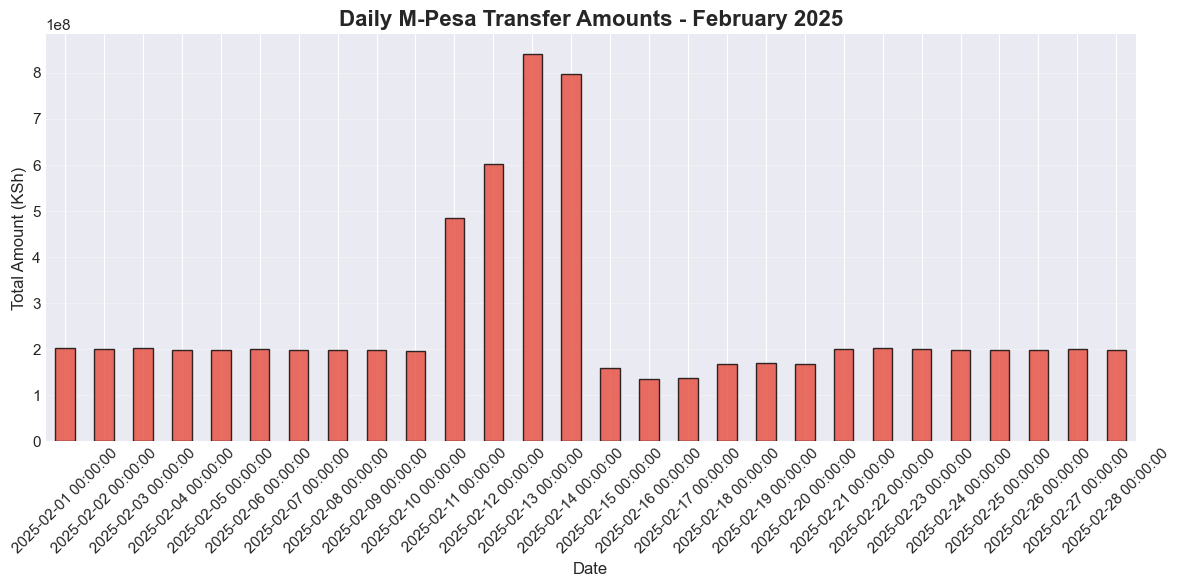

In [ ]:
# Visualize daily mpesa transfer amounts on February 2025
plt.figure(figsize=(12,6))
full_df.groupby('date')['amount'].sum().plot(kind='bar', color='#e74c3c', alpha=0.8, edgecolor='black')
plt.title('Daily M-Pesa Transfer Amounts - February 2025', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12) 
plt.ylabel('Total Amount (KSh)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# compare amount sent on 2025-02-12 vs 2025-02-13 vs 2025-02-14
amount_feb12 = full_df[full_df['date'] == datetime(2025, 2, 12)]['amount'].sum().round(2)
amount_feb13 = full_df[full_df['date'] == datetime(2025, 2, 13)]['amount'].sum().round(2)
amount_feb14 = full_df[full_df['date'] == datetime(2025, 2, 14)]['amount'].sum().round(2)
print("\n Amount Comparison for Feb 12, 13, and 14:")
print(f"  Feb 12, 2025: KSh {amount_feb12:,.2f}")
print(f"  Feb 13, 2025: KSh {amount_feb13:,.2f}")
print(f"  Feb 14, 2025: KSh {amount_feb14:,.2f}")


 Amount Comparison for Feb 12, 13, and 14:
  Feb 12, 2025: KSh 602,981,931.04
  Feb 13, 2025: KSh 841,288,026.94
  Feb 14, 2025: KSh 798,556,858.58


### Post-valentine Recovery Pattern

In [ ]:
# post-valentine dip in volume and % decline( comparing valentine vs post-valentine)
post_valentine_df = full_df[full_df['period'] == 'post_valentine']
post_valentine_daily_avg = len(post_valentine_df) / 14 #14 days representing post-valentine period
decline_percentage = ((valentine_daily_avg- post_valentine_daily_avg) / baseline_daily_avg) * 100
print(f"\n Post-Valentine's daily average number of transactions: {post_valentine_daily_avg:,.0f} transactions")
print(f" Decline in volume of transactions from Valentine (%): {decline_percentage:.1f}%")   


 Post-Valentine's daily average number of transactions: 55,754 transactions
 Decline in volume of transactions from Valentine (%): 154.3%


In [ ]:
# volume of message_type during post-valentine
post_message_analysis = post_valentine_df['message_type'].value_counts()
print("\n Post-Valentine's Message Type Distribution:")
post_message_analysis



 Post-Valentine's Message Type Distribution:


message_type
General Transfer    773382
Apology               7175
Name: count, dtype: int64

In [ ]:
# Actual date: datewise volume of message_type during post-valentine
post_message_datewise = post_valentine_df.groupby(['date', 'message_type']).size().unstack(fill_value=0)
post_message_datewise
print(f"Actual date where Aplogies messages spiked: {post_message_datewise.idxmax()['Apology'].date()} with {post_message_datewise.max()['Apology']:,} Apology messages sent.")

Actual date where Aplogies messages spiked: 2025-02-15 with 7,175 Apology messages sent.


In [ ]:
# average amount by message_type during post-valentine
post_message_amounts = post_valentine_df.groupby('message_type')['amount'].mean().round(2)
print("\n Post-Valentine's Average Amount by Message Type:")
print(post_message_amounts)


 Post-Valentine's Average Amount by Message Type:
message_type
Apology             3903.50
General Transfer    3242.89
Name: amount, dtype: float64


**Insight**:

There were about 7,175 apology messages sent post-valentine

✓ Saved: post_valentine_recovery.png


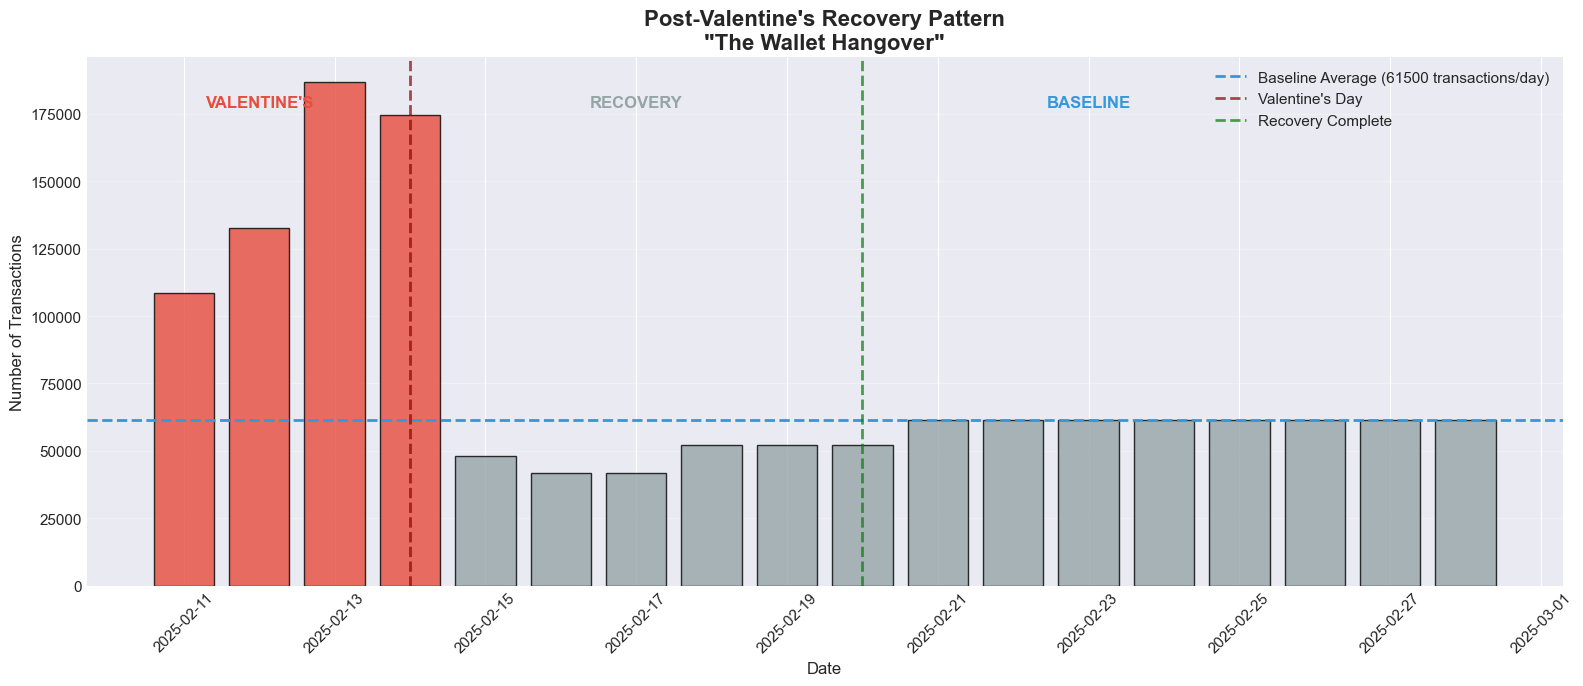

In [ ]:
# Visualization: Post-Valentine recovery pattern
fig, ax = plt.subplots(figsize=(16, 7))
post_val_daily = full_df[full_df['period'].isin(['valentine', 'post_valentine'])]\
    .groupby('date').size()

colors_recovery = ['#e74c3c' if d.day <= 14 else '#95a5a6' for d in post_val_daily.index]
ax.bar(post_val_daily.index, post_val_daily.values, color=colors_recovery, 
       alpha=0.8, edgecolor='black')

# Add baseline reference line
baseline_avg = len(baseline_df) / 10
ax.axhline(baseline_avg, color='#3498db', linestyle='--', linewidth=2, 
           label=f'Baseline Average ({baseline_avg:.0f} transactions/day)')

ax.axvline(datetime(2025, 2, 14), color='darkred', linestyle='--', linewidth=2, 
           alpha=0.7, label='Valentine\'s Day')
ax.axvline(datetime(2025, 2, 20), color='green', linestyle='--', linewidth=2, 
           alpha=0.7, label='Recovery Complete')

ax.set_title('Post-Valentine\'s Recovery Pattern\n"The Wallet Hangover"', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Transactions', fontsize=12)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add period labels
ax.text(datetime(2025, 2, 12), post_val_daily.max() * 0.95, 'VALENTINE\'S', 
        fontsize=12, ha='center', color='#e74c3c', fontweight='bold')
ax.text(datetime(2025, 2, 17), post_val_daily.max() * 0.95, 'RECOVERY', 
        fontsize=12, ha='center', color='#95a5a6', fontweight='bold')
ax.text(datetime(2025, 2, 23), post_val_daily.max() * 0.95, 'BASELINE', 
        fontsize=12, ha='center', color='#3498db', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('post_valentine_recovery.png', dpi=300, bbox_inches='tight')
print("✓ Saved: post_valentine_recovery.png")
plt.show()
plt.close()

### Valentine Day's Transfer Percentile Analysis

In [ ]:
# 3. Percentile analysis
print("\n4. VALENTINE'S TRANSFER PERCENTILE BREAKDOWN")
print("-"*70)
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(valentine_df['amount'], p)
    print(f"  {p}th percentile: KSh {value:,.2f}")

print("\n  Top 1% of transfers (99th percentile+):")
top_1_percent = valentine_df[valentine_df['amount'] >= np.percentile(valentine_df['amount'], 99)]
print(f"    Count: {len(top_1_percent):,}")
print(f"    Average: KSh {top_1_percent['amount'].mean():,.2f}")
print(f"    Total value: KSh {top_1_percent['amount'].sum():,.2f}")


4. VALENTINE'S TRANSFER PERCENTILE BREAKDOWN
----------------------------------------------------------------------
  10th percentile: KSh 300.00
  25th percentile: KSh 400.00
  50th percentile: KSh 900.00
  75th percentile: KSh 2,000.00
  90th percentile: KSh 8,000.00
  95th percentile: KSh 10,000.00
  99th percentile: KSh 82,344.47

  Top 1% of transfers (99th percentile+):
    Count: 6,027
    Average: KSh 91,189.08
    Total value: KSh 549,596,600.88


### Correlation Analysis

In [ ]:
# 2. Correlation analysis
print("\n3. CORRELATION ANALYSIS")
print("-"*70)

# Hour vs Amount correlation
hour_amount_corr = valentine_df[['hour', 'amount']].corr().iloc[0, 1]
print(f"Hour vs Amount correlation: {hour_amount_corr:.4f}")
print(f"  Interpretation: {'Weak' if abs(hour_amount_corr) < 0.3 else 'Moderate' if abs(hour_amount_corr) < 0.7 else 'Strong'} correlation")

# Location type encoding for correlation
valentine_df_encoded = valentine_df.copy()
valentine_df_encoded['location_numeric'] = valentine_df_encoded['location_type'].map({'Urban': 1, 'Rural': 0})
location_amount_corr = valentine_df_encoded[['location_numeric', 'amount']].corr().iloc[0, 1]
print(f"\nUrban/Rural vs Amount correlation: {location_amount_corr:.4f}")
print(f"  Interpretation: {'Urban' if location_amount_corr > 0 else 'Rural'} areas tend to send {'higher' if location_amount_corr > 0 else 'lower'} amounts")


3. CORRELATION ANALYSIS
----------------------------------------------------------------------
Hour vs Amount correlation: 0.0009
  Interpretation: Weak correlation

Urban/Rural vs Amount correlation: -0.0004
  Interpretation: Rural areas tend to send lower amounts


# Summary Insights of ❤️ Love in the Time of Mobile Money

Mobile money has profoundly integrated into Kenyan romance, with Valentine's Day sparking significant digital gifting activity, as revealed by modeled data.

---

## 1. 📈 Transaction Volume & Behavioural Surge

* **Valentine's week surge:** **145% increase** in M-Pesa P2P transfers compared to the baseline.
* **Daily transfers:** Rises from **1.23 transfers/user to 3 transfers/user**.
* **Total "love transfers" (Feb 11–14):** $\sim$**602,700** transactions.
* **Surge concentration:** Feb 13–14, indicating **last-minute behaviour**.
* **Feb 13 "panic sending":**
    * 186,837 transfers (**9.4%** of week’s volume).
    * KES 841M sent (**11.6%** of total value).
* **Post-Valentine dip (Feb 15–28):** **154% drop** in P2P transfers (55,754 transactions less).

---

## 2. 💰 Transfer Amounts & Spending Personas

Aggregate transaction amounts during the period:
* Total: **KES 2.73 billion** ($21.1M)
* Mean: **KES 4,526**
* Median: **KES 900**
* Mode: **KES 300**

$$
\text{Aggregate Value} = \text{KES } 2.73 \text{ Billion} \quad | \quad \text{Mean} = \text{KES } 4,526
$$

| Persona | % of Users | Avg Amount (KES) | Behaviour |
| :--- | :---: | :---: | :--- |
| Micro-Romantics | 36% | 333 | Small thoughtful gestures |
| Budget Romantics | 38% | 1,157 | Practical gifts (lunch/flowers) |
| Mid-Range Sweethearts | 21% | 5,850 | Date nights, hotels |
| Big-Hearted Lovers | 2% | 29,248 | Large or premium gifts |
| Ultra-Romantics | 3% | 75,016 | High-end surprises |
| Big Spenders | <1% | 100,000+ | Luxury-level gifting |

> **Insight:** The **majority of senders spend under KES 2,000**, making digital romance inclusive and affordable.

---

## 3. 🕒 Temporal Patterns (When Kenyans Send Love Money)

* **Peak sending windows (Feb 14):**
    * 07:00–09:00: Morning surprises (**14%**), represents an average of KES 4,529
    * 12:00–14:00: Lunch-hour declarations (**19%**), represents an average of KES 4,484
    * **17:00–20:00: Evening romance peak (33%)**, represents an average of KES 4,537
    * 20:00–23:00: Last-minute redemptions (**11%**), represents an  average of KES 4,553
* **Busiest individual hour:** **7 pm** (56,886 transfers, amounting to KES 259M).

> **Insight:** Sending intensifies as the day unfolds, **culminating in evening gifting**.

---

## 4. 🌍 Geographic Patterns (Where Love Flows)

* **Top Counties:**
    1.  **Nairobi:** **34%** of Valentine transfers.
    2.  Mombasa: 12%
    3.  Kilifi: 10%
    4.  Kiambu: 9.9%
    5.  Narok:  8.1%
* **Urban vs Rural:**
    * Urban senders: **61%** of transactions, resulting in an average of KES 4,534
    * Rural senders: 32% of transactions, resulting in an average of KES 4,522

> **Insight:** **Urban economic hubs drive digital gifting**, with Nairobi alone handling one-third of Valentine transfers. 

---

## 5. 👩‍❤️‍👨 Gender Dynamics in Love Transfers

* **Male → Female:** **62%**, resulting in an average of KES 4,524
* Female → Male: 28%
* Male → Male: 4%
* Female → Female: 6%

> **Insight:** **Traditional gifting patterns persist** — men send more often and in higher amounts;conforming to the broader social expectations around Valentine's gifting.

---

## 6. 💬 Message Description Analysis (What Kenyans Say)

* **Top transaction description messages:**
    * "Happy Valentine’s ❤️" – 18%
    * "Hii ni ya lunch babe" – 15%
    * "Nakupenda sana💕" – 12%
* **Other popular examples:**
    * "Happy Mens Conference 🍻"
    * "Emergency Valentines for You"
    * "Iko nini Baby Girl? Check your Mpesa"

> **Insight:** Love messages act as **micro-cultural expressions** showing humour, spontaneity, and Kenyan romance norms. A standout: “Happy Mens Conference 🍻” shows the annual Kenyan meme tradition is alive digitally.

---


## 7. 🧠 Behavioural & Cultural Insights

* **Dinner Club effect:** Evening transfers (5pm-8pm) on Valentine's Day have **10% higher** average amount.
* **The "Last-Minute Lover" Phenomenon**: 9.4% of all Valentine's transfers (represented by 186,837 transfers) occur on February 13 (Reasons: Late birds coming from work or reminded by gazillion Valentine's updates on social media platforms).
* **The "Apology Tour Transfer"**:February 15 shows a spike in transfers with "apology" keywords; about 7,175 messages containing “apology” were sent.Average "apology transfer" amount is KES 3,903.


---

## 🎯 Overall Conclusions

* Mobile money is a **central component of modern Kenyan romance**.
* Small digital gifts are **culturally meaningful**.
* Valentine’s gifting patterns reflect gender norms, urban lifestyles, and digital behaviour.
* **Procrastination is universal** — Feb 13 panic transfers are real.
* **Love has a price point** - around KES 4,526.54 ($35.09) on average
* M-Pesa continues to **shape courtship rituals, relationship expectations, and social performance.**